# Setup

In [1]:
!pip install datasets
from datasets import Dataset, DatasetDict

import json
import re, os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
from collections import defaultdict
from tqdm import notebook as tqdm
from sklearn.model_selection import train_test_split
import random
random.seed(42)
try:
    assert torch.cuda.is_available()
    device = torch.device("cuda")
except:
    device = torch.device("cpu")
print("Using device:", device)

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
!pip install unidecode
from unidecode import unidecode
import unicodedata
import re
import html

def normalize_text(text):
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD', text)
    text = unidecode(text)
    text = re.sub(r"\s+", " ", text)
    return text

Using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 11.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder = f"/content/drive/MyDrive/DH"
QP_FOLDER = f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/TO-USE"

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, CrossEncoder, util, models
from sentence_transformers.util import semantic_search, pytorch_cos_sim

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully un

## Load Bibles

In [3]:
bible = {}

to_remove = {}
items = pd.read_csv(f"{folder}/EEPS/overly_vague.csv").to_dict(orient='records')
for entry in items:
  if entry['to_remove'] is True:
    to_remove[entry['verse_id']] = None

print('To Remove', len(to_remove))

b_versions = ['AKJV','ODRV','Geneva', 'Douay-Rheims', 'Tyndale', 'Wycliffe','Vulgate']
for bname in b_versions:
    data = pd.read_csv(f"{folder}/Bibles/{bname}.csv",header=None)
    data = data.to_dict(orient="records")
    for entry in tqdm.tqdm(data):
        key = entry[0]
        if key in to_remove: continue
        v_id = key.split(" (")[0]
        text = entry[6]
        if re.search("Douay-Rheims",key):
            if re.sub("Douay-Rheims","ODRV",key) in bible: continue
        if len(text.split(" ")) < 200:
            bible[key] = normalize_text(f"{v_id}: {text}")

        parts = re.split(r'(?<=[\.\?]) (?=[A-Z])|(?<=[\!\:\;])', text)
        parts = [re.sub(r'\s+', ' ', p).strip() for p in parts if len(p.strip(" ")) > 0]
        if (len(parts[0].split(" ")) <= 5 or len(parts[-1].split(" ")) <= 5 or re.search(r"\&\w+\;",parts[0])):
            for pidx, p in enumerate(parts): continue
        elif len(parts) > 1:
            for pidx, p in enumerate(parts):
              p_id = f"{key} - {pidx}"
              if p_id in to_remove: continue
              if len(p) == 0: continue
              if re.search(r"\&\w+\;",p) or len(p.split(" ")) <= 5: continue
              bible[p_id] = normalize_text(f"Part {pidx+1} of {v_id}: {p}")

bible['NonQP 0.0'] = 'None'
bible_verses = list(bible.values())
bible_ids = list(bible.keys())
verse_to_id = {v:k for k,v in bible.items()}
bible_parts = {}
for key, text in bible.items():
  v_id = key.split(" - ")[0]
  if v_id not in bible_parts:
    bible_parts[v_id] = [v_id]
  if " - " not in key: continue
  bible_parts[v_id].append(key)

def get_parts(pos_id):
  parts = []
  if len(bible_parts[pos_id]) > 0:
      for part_id in bible_parts[pos_id]:
        parts.append(part_id)
  return parts

v_id_to_idx = {v_id:idx for idx, v_id in enumerate(bible_ids)}
bible_verses_no_prepend = [re.sub(r"^[\d\w\s]+\d+\.\d+\: |^Part \d+ of [\d\w\s]+\d+\.\d+\: ",'',v) for v in bible_verses]
bible["Genesis 1.2 (AKJV) - 0"], bible_verses_no_prepend[v_id_to_idx["Genesis 1.2 (AKJV) - 0"]]
len(bible_verses), len(bible_parts)

To Remove 667


  0%|          | 0/36702 [00:00<?, ?it/s]

  0%|          | 0/14736 [00:00<?, ?it/s]

  0%|          | 0/31090 [00:00<?, ?it/s]

  0%|          | 0/35811 [00:00<?, ?it/s]

  0%|          | 0/7954 [00:00<?, ?it/s]

  0%|          | 0/9622 [00:00<?, ?it/s]

  0%|          | 0/35809 [00:00<?, ?it/s]

(275990, 156757)

## Load top Bible book abbreviations

In [4]:
# top abbreviations or Bible names cited with a chapter or verse number within sermons
with open(f"{folder}/Bibles/top_abbrev.json") as file:
  abbrev = json.load(file)
new = {}
for a,b in abbrev.items():
  if a == b:
    new[a.capitalize()] = b.capitalize()
  else:
    new[a.capitalize()] = b.capitalize() + "."
abbrev = new
print(abbrev)

{'Canticles': 'Cant.', 'Hosea': 'Hos.', 'Ezekiel': 'Ezek.', 'Psalms': 'Psal.', 'John': 'John', 'Hebrews': 'Heb.', 'Isaiah': 'Isa.', 'Romans': 'Rom.', 'Philippians': 'Phil.', 'Corinthians': 'Cor.', 'Matthew': 'Mat.', 'Jeremiah': 'Jer.', 'Proverbs': 'Prov.', 'Acts': 'Acts', 'Kings': 'King.', 'Verse': 'Ver.', 'Revelation': 'Rev.', 'Luke': 'Luke', 'Chronicles': 'Chron.', 'Timothy': 'Tim.', 'James': 'Jam.', 'Peter': 'Pet.', 'Titus': 'Tit.', 'Jude': 'Iud.', 'Ephesians': 'Eph.', 'Colossians': 'Col.', 'Galatians': 'Gal.', 'Deuteronomy': 'Deut.', 'Samuel': 'Sam.', 'Job': 'Job', 'Genesis': 'Gen.', 'Micah': 'Micah', 'Lamentations': 'Lam.', 'Leviticus': 'Levit.', 'Exodus': 'Exod.', 'Zephaniah': 'Zeph.', 'Wisdom': 'Wisd.', 'Daniel': 'Dan.', 'Judges': 'Judg.', 'Joshua': 'Josh.', 'Mark': 'Mark', 'Habakkuk': 'Hab.', 'Thessalonians': 'Thes.', 'Esther': 'Es.', 'Ecclesiastes': 'Eccles.', 'Zechariah': 'Zach.', 'Ezra': 'Ezra', 'Amos': 'Amos', 'Malachi': 'Mal.', 'Numbers': 'Numb.', 'Haggai': 'Hag.', 'Jonah'

## Load Parallel Verses & Cross Refs

In [5]:
def get_parallel_data():
    with open(f"{folder}/Bibles/PARALLEL_VERSES.json") as file:
      p_data, PV = json.load(file)

    new_p_data = {}
    for key, entry in tqdm.tqdm(p_data.items()):
      query = {'q_id':key,
                'queries':{},
                'pos':[]}
      for q_id in entry['pos']:
        if q_id not in bible: continue
        query['pos'].append(q_id)
        verse_text = bible_verses_no_prepend[v_id_to_idx[q_id]]
        query['queries'][q_id] = verse_text
        for part_id in bible_parts.get(q_id, []):
          if part_id == q_id or part_id not in bible: continue
          verse_text = bible_verses_no_prepend[v_id_to_idx[part_id]]
          query['queries'][part_id] = verse_text
          query['pos'].append(part_id)
      skip = True
      for q_id in query['pos']:
        if 'AKJV' in q_id:
          skip = False
      if not skip:
        new_p_data[key] = query
    return new_p_data, PV

parallel, PV = get_parallel_data()
len(parallel), len(PV)

  0%|          | 0/31175 [00:00<?, ?it/s]

(31108, 251257)

In [6]:
parallel['1 Chronicles 11.22'], PV['1 Paralipomenon 11.22 (Douay-Rheims)']

({'q_id': '1 Chronicles 11.22',
  'queries': {'1 Chronicles 11.22 (Geneva)': 'Benaiah the sonne of Iehoiada (the sonne of a valiant man) which had done many actes, and was of Kabzeel, he slewe two strong men of Moab: he went downe also and slewe a lion in the middes of a pit in time of snowe.',
   '1 Chronicles 11.22 (Geneva) - 0': 'Benaiah the sonne of Iehoiada (the sonne of a valiant man) which had done many actes, and was of Kabzeel, he slewe two strong men of Moab:',
   '1 Chronicles 11.22 (Geneva) - 1': 'he went downe also and slewe a lion in the middes of a pit in time of snowe.',
   '1 Paralipomenon 11.22 (Douay-Rheims)': 'Banaias the son of Joiada, a most valiant man, of Cabseel, who had done many acts: he slew the two ariels of Moab: and he went down, and killed a lion in the midst of a pit in the time of snow.',
   '1 Paralipomenon 11.22 (Douay-Rheims) - 0': 'Banaias the son of Joiada, a most valiant man, of Cabseel, who had done many acts:',
   '1 Paralipomenon 11.22 (Douay-

In [7]:
with open(f"{folder}/EEPS/cross_references.json",'r') as file:
  CR = json.load(file)
len(CR)

29364

## Essential Helper Functions

In [8]:
def get_model_hits(data, model_checkpoint, model_name, state_dict_path, retrieve_k=200):
  if model_name == 'MacBERTh':
    word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
    bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
  else:
    bi_encoder = SentenceTransformer(model_checkpoint)

  if state_dict_path:
    model_name = state_dict_path
    bi_encoder.load_state_dict(torch.load(f'{folder}/models/{state_dict_path}.pt'))

  EEPS_files = set(os.listdir(f"{folder}/EEPS"))
  vec_file_name = f"Bibles_{model_name}.pt"
  if vec_file_name not in EEPS_files:
    bible_vectors = bi_encoder.encode(bible_verses, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
    torch.save(bible_vectors, f"{folder}/EEPS/"+vec_file_name)
  bible_vectors = torch.load(f"{folder}/EEPS/"+vec_file_name,map_location=device)
  if data:
    queries = [entry['question'] for entry in data]
    test_vectors = bi_encoder.encode(queries, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
    hits = semantic_search(test_vectors,bible_vectors[:-1],query_chunk_size=1000,top_k=retrieve_k)
    return hits
  else:
    return bi_encoder, bible_vectors

In [9]:
pattern = r'\b(' + '|'.join(re.escape(word) for word in abbrev) + r')\b'
def replace(match):
  return abbrev[match.group(0)]

def get_abbrev_id(q_id):
  return re.sub(pattern, replace, q_id).split(" (")[0]

def add_citation(text, q_id,chapter_only=False,verse_only=False,prepend_only=False,postpend_only = False):
  abbrev_id = get_abbrev_id(q_id)
  chap_id = re.sub(pattern, replace, q_id.split(".")[0])
  text = text.strip(r"[.:;,?]")
  variants = []
  if not verse_only:
    if not prepend_only:
      variants.append("{}, {}".format(text, chap_id)) # Text, Ref. 1
      variants.append("{}, as in {}".format(text, chap_id)) # Text, as in Ref. 1.
    if not postpend_only:
      variants.append("{}, {}".format(chap_id, text)) # Ref. 1, Text
      variants.append("As in {}, {}".format(chap_id, text)) # As in Ref. 1, Text

  if not chapter_only:
    if not postpend_only:
      variants.append("{}, {}".format(abbrev_id, text)) # Ref. 1.1, Text
      variants.append("As in {}, {}".format(abbrev_id, text)) # As in Ref. 1.1., Text
    if not prepend_only:
      variants.append("{}, {}".format(text, abbrev_id)) # Text. Ref. 1.1
      variants.append("{}, as in {}".format(text, abbrev_id)) # Text, as in Ref. 1.1.
  return variants

add_citation("In the beginning God created the Heauen, and the Earth.", 'Genesis 1.1 (AKJV)')

['In the beginning God created the Heauen, and the Earth, Gen. 1',
 'In the beginning God created the Heauen, and the Earth, as in Gen. 1',
 'Gen. 1, In the beginning God created the Heauen, and the Earth',
 'As in Gen. 1, In the beginning God created the Heauen, and the Earth',
 'Gen. 1.1, In the beginning God created the Heauen, and the Earth',
 'As in Gen. 1.1, In the beginning God created the Heauen, and the Earth',
 'In the beginning God created the Heauen, and the Earth, Gen. 1.1',
 'In the beginning God created the Heauen, and the Earth, as in Gen. 1.1']

In [10]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def plot_normal(data, xlabel='Cosine Similarity',model_name=None):
  mean = np.mean(data)
  std = np.std(data)

  x = np.linspace(min(data), max(data), 100)
  pdf = norm.pdf(x, mean, std)
  plt.plot(x, pdf)
  plt.title(f'{model_name}\nMean={mean:.2f}, Std={std:.2f}')
  plt.xlabel(xlabel)
  plt.ylabel('Probability Density')
  plt.show()

def make_batches(data,batch_size=10000):
  data = [k for k in data]
  batches = []
  for start_index in range(0, len(data), batch_size):
    batch = data[start_index:start_index + batch_size]
    batches.append(batch)
  print(len(batches), 'batches')
  return batches

In [11]:
def fix_name(v_id):
  if "1 Kings" in v_id: v_id = "3 Kings" + v_id.split("1 Kings")[-1]
  elif "2 Kings" in v_id: v_id = "4 Kings" + v_id.split("2 Kings")[-1]
  elif "1 Samuel" in v_id: v_id = "1 Kings" + v_id.split("1 Samuel")[-1]
  elif "2 Samuel" in v_id: v_id = "2 Kings" + v_id.split("2 Samuel")[-1]
  elif re.search(r"^\d+ Chronicles",v_id): v_id = re.sub(r"Chronicles","Paralipomenon",v_id)
  return v_id

# About


## Passages to Retrieve (Verses and subverses from different Bibles)##
I prepend verse ids (without version information) to the passages to increase the model's sensitivity to citation information in a given query. This approach assumes that the citation within a query sentence is accurate, which is not always true for my actual corpus of sermons because my segmentation procedure might attach a citation for a passage to the prior or succeeding passage. There may also be various quotations, with or without corresponding citations, in a single passage query. These are complexities that I must capture in my artifical training data. I construct training and development data from Biblical texts, but I ultimately test with a sample of true quotations/paraphrases from the sermons. When actually mining for quotations from sermons, I will postpend marginal notes that are relatively short and contain citations to each segmented sermon passage.

Significant partial verses are ones that are not overly vague (e.g., "Thus saith the Lord the God of Israel:"), have more than five words when tokenized by white space, and do not belong in a parent verse that begins or ends with a short phrase (five or fewer words long). This last condition is based on an assumption that the verses themselves do not usually contain more than two subverses; indeed, the average number of words demarcated by white spaces is only 23. The overly vague parts have been mined in advance, but there are still full verses that are overly vague.             

MacBERTh is uncased, but I retain casing for the passages for ease of reading. Because this retriever prioritizes semantic rather than lexical similarity, I normalize all unicode and HTML characters in the Biblical passages. Moreover, the TCP transcriptions do not include macrons for many words that should have omitted characters, e.g., "cofesse" instead of "cōfesse" for "confess". However, I do not correct or standardize any spellings. (Note: I do have regularized/standard spellings generated by MorphAdorner2.0 for my sermons corpus, but I will not use them for any purpose except as an additional feature in my CRF model for citation span identification).

Here is a mapping of ids to passages.
- Verse Format
  - "Reference x.y (Version)": "Reference x.y Text of verse"
  - 'Genesis 1.2 (AKJV)': 'Genesis 1.2: And the earth was without forme, and voyd, and darkenesse was vpon the face of the deepe: and the Spirit of God mooued vpon the face of the waters.'
- Subverse Format
  - "Reference x.y (Version) - 0": "Part 1 of Reference x.y Subverse text"
  - 'Genesis 1.2 (AKJV) - 0': 'Part 1 of Genesis 1.2: And the earth was without forme, and voyd, and darkenesse was vpon the face of the deepe:'

##Possible Query Types:##

*NOTE*: There may be variants for each query from each version: a variant may have a prepended or postpended verse or chapter citation (most common Bible book abbreviation/name + verse number without version information). The citation may only be the book abbrev/name with a verse or chapter number, or it may come after an additional phrase of "[Aa]s in".

- **FullVerse**: Full Bible verse. Positives should only be full Bible verses. Each parallel verse has the two chapter-only and no-citation variants; during training and evaluation, I will randomly pick one from these 3*N possibilities where N is the number of parallel verses for a verse from the AKJV (including the AKJV verse itself).
  - Parallel verses were mapped using [STEPBible.org's TVTMS data](https://github.com/STEPBible/STEPBible-Data/blob/master/TVTMS%20-%20Translators%20Versification%20Traditions%20with%20Methodology%20for%20Standardisation%20for%20Eng%2BHeb%2BLat%2BGrk%2BOthers%20-%20STEPBible.org%20CC%20BY.txt), which provides tests and versification correspondences for major scriptural traditions. I applied those individual tests to each applicable verse across the seven different Bibles used here.
- **Subverse**: A significant part of a Bible verse, i.e., a subverse that is not overly vague or short. The appended citations do not include subverse indices. I use a retriever fine-tuned with full verses with map parallel subverses. Positives should be their parent verses; I do not train with parallel subverses because those are relatively the same lengths as each other, hence symmetric. The FullVerse case already trains and evalutes symmetric retrieval.  There are five variants per subverse from each version of the Bible.
- **ProperNoun**: A proper noun referenced in that particular verse. During the preprocessing stage, I compile approximate spellings of that noun from each Bible version. These types of queries will help the model differentiate between different versions of the Bible. I also include the standard spelling as a query for each version. For nouns with a greater than average number of references, I sample multiple of these verses that are known cross references to append to the noun.
  - The dataset of proper nouns comes from [STEPBible.org's TINPR data](https://github.com/STEPBible/STEPBible-Data/blob/master/TIPNR%20-%20Translators%20Individualised%20Proper%20Names%20with%20all%20References%20-%20STEPBible.org%20CC%20BY.txt) ("Translators Individualised Proper Names with all References"). I also make a few additions of my own: "ariel", "stone-squarers", and "idols" as a substitute for "household gods". The limitation of TINPR is that its annotators refer only to the ESV, KJV, and NIV. I must find corresponding noun phrases in the other versions that I use.  
  - For multi-word expressions and lower-case words, I use the difflib library's SequenceMatcher function with a similarity threshold of 0.7 and all unigrams to 5-grams. I also use MacBERTh to find semantic matches within the parallel verses of each reference of the two aforementioned types of noun phrases. I only count the first lexical or semantic match of a noun for each reference of that noun. For the remaining references associated with at least one noun phrase, I include all capitalized text in their parallel verses, even if such words may not strictly correspond to entries within this set of proper noun phrases.
- **Hybrid**: These are queries that include either the complete or partial verse of the Vulgate and the parallel text from the other English versions. There are many variants here with citations prepended or not, with the Latin preceding the English or vice versa, and with a full verse with a subverse or vice versa or both matching. All possible variants are included, and one is randomly sampled for each epoch of training. The appended citation is either from the Latin or English KJV versification tradition. These should have multiple positives per query (the English and the Latin verse).
- **CrossRef**: Cross references from [OpenBible](https://www.openbible.info/labs/cross-references/). I use a retriever fine-tuned with parallel verses in order to include cross references above a certain cosine similarity threshold as positives and those below another threshold as hard negatives. I will represent these in a graph as directed edges sized by their weights (similarity scores). These also have cited variants.
- **Combos**: These are queries that contain 2-3 short verses (either cross references or successive verses) with or without citations such that the query does not exceed the maximum sequence length for the tokenizer (512 tokens). These also include combinations of proper nouns with citations.
- **CitationOnly**: Full marginal notes that only contain citations without any quoted or paraphrased text. These will only have one query text, the note itself, and one positive passage (ID: NonQP 1.1, Passage: "No Biblical quotation or paraphrase found")


## Rounds of Training
I use MultipleNegativesRankingLoss, which uses in-batch negatives in addition to any hard negatives that I pass into the model. My batch size is 64. In order to avoid cross references being in the same batch, I use a greedy coloring algorithm and add all verse ids within batches that have a resulting size less than 64 to my development set. I reorder my training data so that they match their order across the batches when the batches are flattened into a single list. This ensures that when I disable shuffling when initializing a DataLoader instance, I can preserve these batches.

Notes on terminology: The **master verse id** is the key I use to organize all parallel verses. The set of master verse ids is equivalent to the ids of full verses in the AKJV Bible dataset without version info (e.g., the master id for "Genesis 1.1 (AKJV)" and "Genesis 1.1 (ODRV)" etc. is "Genesis 1.1"). I use the AKJV here because it is nearly identical to the English Standard Version, which OpenBible uses for its comprehensive cross references dataset.

**Accuracy** is defined as whether a model can correctly predict the similarity between a query and positive as greater than that between the query and a negative for triplets of (query/anchor, positive, negative).

**Recall @ k** (hereafter R@k) reflects the proportion of known positives that a model predicts for a query within its top k results. The metric I truly care for is R@200 because having a true positive within the top couple hundred retrieved results enables me to refine those results with a reranker (either another fine-tuned bi-encoder or a cross-encoder). I also care at R@6 because the average number of positives I labeled for each test example is 6.23.

**Fuzzy Precision @ k** (hereafter FP@k) is the proportion of the top k results that are either exact matches, parallel verses, or cross references of any of the known positives. I calculate "fuzzy" precision because I do not want my biases in my test set to interfere with my models' ability to predict more similar verses and Bible versions for sermon passages. I cannot promise that I labeled all the possible positives for a particular passage with Biblical citations, especially when I add in a larger set of labeled examples where I only did pairwise comparisons between passages and top predictions from the off-the-shelf MacBERTh model. For a "Golden Set" of just over a hundred passages, I did try to label and rank all possible matches from all versions, but that is not guaranteed to be perfect either. I care about FP@1 because this means that the top result is indeed direcly relevant to that known quotation or paraphrase. I examine FP@6 for the same reason as I do for R@6.
______________________________________





## 1. Symmetric Full Verse Retrieval, Round 1 (Success)
  - Pick a variant of a random positive for each master verse id. Let this be **query_id**.
  - For the positive of the query, randomly pick a positive such that it is not identical to **query_id** and is not from the same version as **query_id**. Moreover, if **query_id** is from a Protestant Bible (AKJV, Geneva, Tyndale), the positive should not be from another Protestant Bible. Instead, pick from a Catholic Bible unless there are none. Let this be **pos_id**.
  - Using base MacBERTh, mine full verses for all positives that are not positives or cross references of any of the positives. Each hard negative have less than 0.98 cosine similarity because MacBERTh similarity scores are all highly skewed towards the high end (see Table 1).
  - On the development set, this approach achieves a maximum of 0.9847 accuracy with two epochs of training. Accuracy begins to drop at the third epoch. Hence, I choose Checkpoint 1014 (=2 epochs) for my resulting model.
  - On the test set of real Biblical quotations/paraphrases from early sermons, this achieves a **0.455** R@200 and **0.412** FP@1. This performance is already much better than off-the-shelf MacBERTh's **0.396** R@200 and **0.36** FP@1. R@6 and FP@6 are roughly equivalent between these two models.

## 2. Asymmetric Retrieval: Subverse to Full Verse (Success)
  - I add subverses (with five variants each, see above) to the pools of queries and positives for each master verse id. I precompute 8 hard negatives for the raw text, i.e., text without any citations, of each verse and subverse because there is an average of 7.46 positives per master id.
  - For hard negative mining, I use the better model from the previous rounds. Checkpoint 1014 from Round 1 actually performs better on similarity scores than Checkpoint 2028 from Round 2 because the latter has been overfitted and is less generalizable to asymmetric retrieval. Moreover, the standard deviations are also slightly higher for Ckpt 2028, meaning that they are slightly less reliable (See Table 1). This also means that I should not train for more than 2 epochs on the same format of data, even if there is variation between the exact texts used per epoch.
  - The resulting model is Checkpoint 1521, which achieves a high of **0.727** on R@200 and **0.57** FP@1. For R@6 and FP@6, I also see significant improvement to 0.401 and 0.5 respectively. These are the best results I've seen so far for the test set across these rounds and the many that I've tried before I outlined my current approach. The average similarity for pairs of parallel verses and between subverses and their parent parallel verses are both the highest I've seen so far except for the undiscerning off-the-self model. Moreover, standard deviations for these similarity scores are also lower.

## 3. Asymmetric Retrieval: Hybrid English and Latin Passages with Multiple Positives Per Epoch

## Table 1 (μ ± σ)
| Comparison Type     |    MacBERTh             | R1 Checkpoint 1014  | R2 Checkpoint 2028 | R3 Checkpoint 1521  |
|-------------------------------------|-----------------|-----------------|-----------------|-----------------|
| Full parallel verses  | 0.92 ± 0.04     | 0.76 ± 0.16     | 0.71 ± 0.19     | 0.82 ± 0.13 |
| Subverses vs. parent verse & parent's parallels | 0.91 ± 0.05 |0.59 ± 0.19     | 0.53 ± 0.21     | 0.66 ± 0.14 |
| Cross references (From -> To) | 0.91 ± 0.04 |0.26 ± 0.17     | 0.24 ± 0.16     | 0.25 ± 0.17 |   

## Table 2 (Recall and Precision Scores)

# Examine Cosine Similarity Scores

In [12]:
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"
state_dict_path = None
model_round = "ALL"
epoch = "1"
state_dict_path = f"EEPS_{model_round}_MacBERTh_Epoch{epoch}"
bi_encoder,bible_vectors = get_model_hits(None, model_checkpoint, model_name, state_dict_path)
if state_dict_path:
  model_name = state_dict_path

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Batches:   0%|          | 0/270 [00:00<?, ?it/s]

In [ ]:
def get_sim_scores(data):
  vectors_1 = torch.stack([bible_vectors[v_id_to_idx[x]] for x,y in data])
  vectors_2 = torch.stack([bible_vectors[v_id_to_idx[y]] for x,y in data])
  vectors_1 = F.normalize(vectors_1, p=2, dim=1)
  vectors_2 = F.normalize(vectors_2, p=2, dim=1)
  vectors_1 = vectors_1.unsqueeze(1)
  vectors_2 = vectors_2.unsqueeze(2)
  sim_scores = torch.bmm(vectors_1, vectors_2)
  sim_scores = sim_scores.squeeze()
  sim_scores = sim_scores.tolist()
  return sim_scores

def get_version(v_id):
  ver = v_id.split(" (")[-1].strip(")")
  trad = "P"
  if ver in ['ODRV','Vulgate','Douay-Rheims','Wycliffe']:
    trad = "C"
  return ver, trad

def pv_sim(full=True):
  pv_scores = {}
  for _, item in tqdm.tqdm(sorted(parallel.items())):
    for q_id in item['pos']:
      if full and " - " in q_id: continue # full verse only
      if not full and " - " not in q_id: continue # subverse only
      for p_id in item['pos']:
        if " - " in p_id: continue # full verse only
        if (p_id, q_id) in pv_scores: continue
        if not full:
          # map subverse to parent verse
          if p_id.split(" - ")[0] != q_id.split(" - ")[0]: continue
        if full:
          # map full verse to parallel verse from another tradition than itself
          if get_version(p_id)[-1] == get_version(q_id)[-1]: continue
        key = (q_id,p_id)
        pv_scores[key] = None
  print(len(pv_scores))

  pv_batches = make_batches(pv_scores)
  for batch in tqdm.tqdm(pv_batches):
    sim_scores = get_sim_scores(batch)
    for idx, score in enumerate(sim_scores):
      q_id, p_id = batch[idx]
      pv_scores[(q_id, p_id)] = score
      # if 0.2 < score <= 0.5 and q_id not in exclude_psalms:
      #   print(score)
      #   print(q_id, '\t',bible[q_id])
      #   print('\t',p_id, bible[p_id],'\n')
  plot_normal(list(pv_scores.values()),model_name=model_name)

### Parallel Verses

  0%|          | 0/31108 [00:00<?, ?it/s]

160064
17 batches


  0%|          | 0/17 [00:00<?, ?it/s]

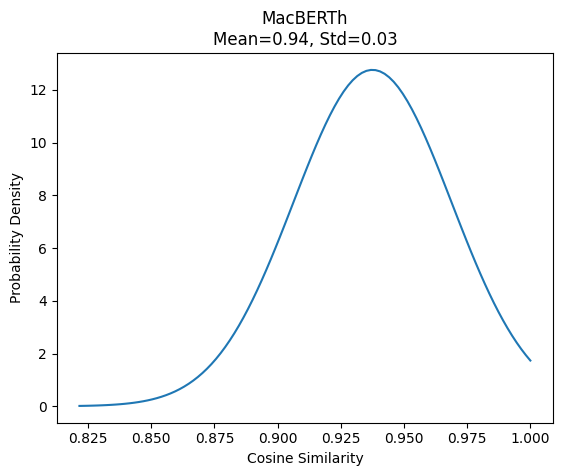

Subverse to Full Verse


  0%|          | 0/31108 [00:00<?, ?it/s]

110187
12 batches


  0%|          | 0/12 [00:00<?, ?it/s]

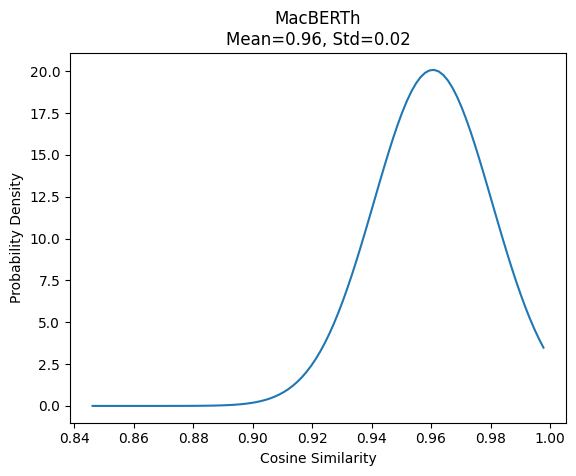

In [ ]:
pv_sim() # MacBERTh
# Mean=0.94, Std=0.03
print("Subverse to Full Verse")
pv_sim(False) # MacBERTh
# Mean=0.96, Std=0.02

### Cross Refs

In [ ]:
check_cr = {}
CR_actual = {}
for master_id, item in tqdm.tqdm(parallel.items()):
  if master_id not in CR: continue
  for q_id in item['pos']:
    if " - " in q_id: continue # full verse only
    q_ver = q_id.split(" (")[-1].strip(")")
    for cr in CR[master_id]:
      if cr in parallel:
        for cr_id in parallel[cr]['pos']:
          if " - " in cr_id: continue # full verse only
          key = (q_id,cr_id)

          # must be from the same version
          cr_ver = cr_id.split(" (")[-1].strip(")")
          if q_ver != cr_ver: continue

          if q_id not in CR_actual:
            CR_actual[q_id] = {}
          CR_actual[q_id][cr_id] = None

          if (cr_id, q_id) in check_cr: continue
          if key not in check_cr: check_cr[key] = set()
          check_cr[key].update({master_id})

len(check_cr), len(CR_actual)

  0%|          | 0/31108 [00:00<?, ?it/s]

(2214567, 131546)

In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json",'w+') as file:
  json.dump(CR_actual, file)

In [ ]:
list(check_cr.items())[52]

(('Genesis 2.24 (Wycliffe)', 'Matthew 19.5 (Wycliffe)'), {'Genesis 2.24'})

In [ ]:
bible['Genesis 2.24 (Wycliffe)'], bible['Matthew 19.5 (Wycliffe)']

('Genesis 2.24: Wherfor a man schal forsake fadir and modir, and schal cleue to his wijf, and thei schulen be tweyne in o fleisch.',
 'Matthew 19.5: And he seide, For this thing a man schal leeue fadir and modir, and he schal draw to his wijf; and thei schulen be tweyne in o fleisch.')

In [ ]:
get_sim_scores([('Matthew 19.5 (Wycliffe) - 1','Matthew 19.5 (Wycliffe)')])

0.9373323917388916

In [ ]:
get_sim_scores([('Genesis 2.24 (Wycliffe)','Matthew 19.5 (Wycliffe)')])

0.9823479652404785

In [ ]:
def cr_sim():
  check_cr_batches = make_batches(check_cr)
  CR_mapping = {}

  for batch in tqdm.tqdm(check_cr_batches):
    sim_scores = get_sim_scores(batch)
    for idx, score in enumerate(sim_scores):
      q_id, cr_id = batch[idx]
      # print(score)
      # print(q_id,bible_verses_no_prepend[v_id_to_idx[q_id]])
      # print(cr_id, bible_verses_no_prepend[v_id_to_idx[cr_id]])
      # print()
      CR_mapping[(q_id, cr_id)] = score
  plot_normal(list(CR_mapping.values()),model_name)

222 batches


  0%|          | 0/222 [00:00<?, ?it/s]

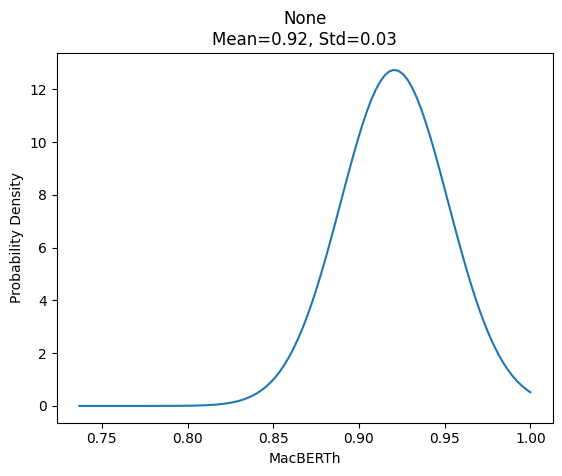

In [ ]:
cr_sim() # MacBERTh
# Mean=0.92, Std=0.03

In [ ]:
del check_cr

#### Use a fine-tuned model to get highly similar CR for Cross Encoder training

In [ ]:
check_cr_batches = make_batches(list(check_cr.keys()))
CR_positives = {}

for batch in tqdm.tqdm(check_cr_batches):
  sim_scores = get_sim_scores(batch)
  for idx, score in enumerate(sim_scores):
    q_id, cr_id = batch[idx]
    if score > 0.4:
      # print(score)
      # print(q_id,bible_verses[v_id_to_idx[q_id]])
      # print(cr_id, bible_verses[v_id_to_idx[cr_id]])
      # print()
      if q_id not in CR_positives:
        CR_positives[q_id] = {}
      CR_positives[q_id][cr_id] = score
len(CR_positives)

223 batches


  0%|          | 0/223 [00:00<?, ?it/s]

96749

In [ ]:
with open(f"{folder}/EEPS/CR_positives.json",'w+') as file:
  json.dump(CR_positives, file)

In [ ]:
check_cr = []
for q_id, crlist in CR_positives.items():
  for cr_id in crlist:
    check_cr.append((q_id, cr_id))

# Datasets

## Latin + English Hybrids


In [ ]:
for query in parallel.values():
  # compile query text
  query['latlist'] = [q_id for q_id in query['queries'].keys() if 'Vul' in q_id]
  query['englist'] = [q_id for q_id in query['queries'].keys() if 'Vul' not in q_id]


class HybridDataset(Dataset):
  def __init__(self,data):
    self.queries = data
    self.queries_ids = list(data.keys())

  def __getitem__(self, item):
    key = self.queries_ids[item]
    query = self.queries[key]

    if len(query['latlist']) > 0:
      lat = random.choice(query['latlist'])
      first_lang = 'lat'
    else:
      return ('', ('',''),key)

    eng = query['englist'].pop(0)
    query['englist'].append(eng)
    lat_text = query['queries'][lat]
    eng_text = query['queries'][eng]
    query_text = "{} {}".format(lat_text, eng_text)
    return (query_text, lat, eng)

  def __len__(self):
    return len(self.queries_ids)

In [ ]:
hybrid_dataset = HybridDataset(parallel)

for i, entry in enumerate(parallel.values()):
  entry['hybrids'] = {}
  for _ in query['englist']:

    query_text, lat, eng = hybrid_dataset[i]
    if query_text == '': continue
    if lat not in entry['hybrids']: entry['hybrids'][lat] = []
    if eng not in entry['hybrids']: entry['hybrids'][eng] = []
    entry['hybrids'][lat].append(query_text)
    entry['hybrids'][eng].append(query_text)
  for v_id, vlist in entry['hybrids'].items():
    entry['hybrids'][v_id] = list(set(vlist))

In [ ]:
list(parallel.values())[0]['hybrids']

{'Genesis 2.24 (Vulgate)': ['Quam ob rem relinquet homo patrem suum, et matrem, et adhaerebit uxori suae: et erunt duo in carne una. Therefore shall man leaue his father and his mother, and shall cleaue to his wife, and they shall be one flesh.',
  'Quam ob rem relinquet homo patrem suum, et matrem, et adhaerebit uxori suae: et erunt duo in carne una. Wherfor a man schal forsake fadir and modir, and schal cleue to his wijf, and thei schulen be tweyne in o fleisch.',
  'Quam ob rem relinquet homo patrem suum, et matrem, et adhaerebit uxori suae: et erunt duo in carne una. Wherfore man shal leaue his father & mother, & shal cleaue to his wife, & they shal be two in one flesh.'],
 'Genesis 2.24 (Wycliffe)': ['Quam ob rem relinquet homo patrem suum, et matrem, et adhaerebit uxori suae: et erunt duo in carne una. Wherfor a man schal forsake fadir and modir, and schal cleue to his wijf, and thei schulen be tweyne in o fleisch.'],
 'Genesis 2.24 (Vulgate) - 1': ['et erunt duo in carne una. Th

## Cross References as Citations

In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json") as file:
  CR_actual = json.load(file)

In [ ]:
for v_id, entry in tqdm.tqdm(parallel.items()):
  entry['cross_refs'] = {}
  for p_id in entry['pos']:
    abbrev_cr = []
    cr_list = CR_actual.get(p_id.split(" - ")[0],[])
    for cr_id in cr_list:
      chap_only = random.choice([0,1])
      if chap_only:
        cr_id = cr_id.split(".")[0]
      abbrev_id = get_abbrev_id(cr_id)
      abbrev_cr.append(abbrev_id)
    entry['cross_refs'][p_id] = list(set(abbrev_cr))

  0%|          | 0/31108 [00:00<?, ?it/s]

In [ ]:
print(parallel['2 Samuel 23.20']['cross_refs'])

{'2 Kings 23.20 (Vulgate) - 0': ['3 King. 2.32', '3 King. 2', '1 Paral. 12', 'Judg. 14', 'Josh. 15', '3 King. 2.33', '1 King. 17.34', '1 King. 17', '1 Paral. 11.24', '1 Paral. 27', '2 King. 20', '1 King. 17.36', '3 King. 2.30', '3 King. 2.35', '3 King. 1', '1 Paral. 11.22', '1 Paral. 11.23', '2 King. 8', 'Judg. 14.5', '1 Paral. 18.17', '2 King. 1.23', 'Exod. 15.15'], '2 Samuel 23.20 (Geneva)': ['1 Chron. 27.6', 'Judg. 14.6', '1 Chron. 11.24', '1 Chron. 11', '1 King. 2.46', 'Judg. 14', 'Josh. 15', '1 King. 1.38', '1 Chron. 12.8', '1 Chron. 18', '1 Sam. 17.34', '1 King. 2.35', '1 King. 2.32', '2 Sam. 8', '1 Sam. 17', '2 Sam. 20.23', '1 King. 1.26', '1 King. 2.30', '1 King. 2', 'Exod. 15.15', '1 Sam. 17.37', '1 King. 2.29', '1 King. 1', '1 Chron. 27.5'], '2 Samuel 23.20 (Geneva) - 0': ['1 Sam. 17', 'Josh. 15', '1 King. 1.8', '2 Sam. 20.23', '1 Chron. 11.23', '1 Chron. 27.6', '1 King. 2', 'Judg. 14.6', '1 Sam. 17.35', '2 Sam. 8', 'Exod. 15.15', '1 Chron. 11', '1 King. 2.29', '1 Chron. 12',

## Non QP

In [ ]:
def get_nonQP_data():
  test_set = {}
  more = pd.read_csv(f"{QP_FOLDER}/MARGINS_NON-QP.csv")
  more = more[more['correction'].str.contains('C_Only')]
  more = list(more['text']) # num tokens 6.61 +/- 4.97
  # plot_normal([len(t.split()) for t in more],'Number of Tokens')
  more = [t for t in more if len(t.split()) <= 7]
  for text in more:
    if text not in test_set: test_set[text] = {'pos': [bible_ids[-1]],
                                              'input': (bible_ids[-1], text, bible_ids[-1])}
  return test_set

NON_QP = get_nonQP_data()
len(NON_QP), list(NON_QP.keys())[12]

(24189, 'Luk. 20. 1•, 20, 21, 22, 23')

## Proper Nouns

In [ ]:
with open(f"{folder}/EEPS/PROPER_NOUN_TO_V_ID.json") as file:
  v_id_to_noun = json.load(file)

len(v_id_to_noun)

14909

In [ ]:
nounlist_to_id = {}
num_nouns = 2
for v_id, nounlist in v_id_to_noun.items():
  if len(nounlist) <= num_nouns: continue
  nounlist = ", ".join(nounlist)
  if nounlist not in nounlist_to_id:
    nounlist_to_id[nounlist] = {}
  for id in PV[v_id]:
    nounlist_to_id[nounlist][id] = True

# subverse_nouns = {}
# for v_id, nounlist in v_id_to_noun.items():
#   for part_id in bible_parts.get(v_id,[]):
#     if part_id == v_id: continue
#     part_nouns = []
#     for noun in nounlist:
#       if noun.lower() in bible_verses_no_prepend[v_id_to_idx[part_id]].lower():
#         part_nouns.append(noun)
#     if len(part_nouns) > num_nouns:
#       subverse_nouns[part_id] = part_nouns
# v_id_to_noun.update(subverse_nouns)

len(nounlist_to_id),list(nounlist_to_id.items())[0]

(11808,
 ('Chelion, Elimelech, Mahalon, Testes, Elimelech, Chelion, Mahalon, Noemi',
  {'Ruth 4.9': True}))

In [ ]:
for noun, id in nounlist_to_id.items():
  if '2 Samuel 23.20' in id:
    print(noun)

Valiant, man, cabseel, Cabseel, Banaias, Joiada, Cabseel, Moab
Lionlike, men, Kabzeel, Benaiah, Iehoiada, Kabzeel, Moab, Lyon
Strong, men, Kabzeel, Benaiah, Iehoiada, Kabzeel, Moab
Cabseel, Banaias, Jojadae, Cabseel, Moab


In [ ]:
for v_id, nounlist in v_id_to_noun.items():
  if len(nounlist) <= num_nouns: continue
  keys = PV[v_id]
  for key in keys:
    if " - " in key: continue
    entry = parallel[key]
    if 'nouns' not in entry:
      entry['nouns'] = {}
    nounlist = ", ".join(nounlist)
    entry['nouns'][v_id] = nounlist
    # texts = add_citation(nounlist,v_id,verse_only=True)

In [ ]:
parallel['2 Samuel 23.20']

{'q_id': '2 Samuel 23.20',
 'queries': {'2 Kings 23.20 (Vulgate) - 0': 'Et Banaias filius Jojadae viri fortissimi, magnorum operum, de Cabseel.',
  '2 Samuel 23.20 (Geneva)': 'And Benaiah the sonne of Iehoiada the sonne of a valiant man, which had done many actes, and was of Kabzeel, slewe two strong men of Moab: he went downe also, and slewe a lyon in the middes of a pit in the time of snowe.',
  '2 Samuel 23.20 (Geneva) - 0': 'And Benaiah the sonne of Iehoiada the sonne of a valiant man, which had done many actes, and was of Kabzeel, slewe two strong men of Moab:',
  '2 Samuel 23.20 (Geneva) - 1': 'he went downe also, and slewe a lyon in the middes of a pit in the time of snowe.',
  '2 Kings 23.20 (Vulgate)': 'Et Banaias filius Jojadae viri fortissimi, magnorum operum, de Cabseel. Ipse percussit duos leones Moab, et ipse descendit, et percussit leonem in media cisterna in diebus nivis.',
  '2 Kings 23.20 (Vulgate) - 1': 'Ipse percussit duos leones Moab, et ipse descendit, et percussi

## Negatives Mining Function

In [ ]:
def is_PV(v_id, q_id):
  if q_id == "NonQP 0.0":
    return False
  if v_id not in PV or q_id not in PV:
    return True
  for id in PV[v_id]:
    if id in PV[q_id]:
      return True
  for id in PV[q_id]:
    if id in PV[v_id]:
      return True
  return False

def is_CR(v_id, q_id):
  if q_id == "NonQP 0.0":
    return False
  if v_id not in PV or q_id not in PV:
    return True
  for q_master_id in PV[q_id].keys():
    for v_master_id in PV[p_id].keys():
      if q_master_id in CR.get(v_master_id, []):
        return True
      if v_master_id in CR.get(q_master_id,[]):
        return True
  return False

def get_negatives(vectors, ids, b_vectors=bible_vectors, full_data = None,NUM_NEGATIVES = 1):
  NEGATIVES = {}
  hits = semantic_search(vectors,b_vectors,query_chunk_size=500,top_k=50)

  for idx, q_key in tqdm.tqdm(enumerate(ids)):
    negs = []
    hitlist = hits[idx]
    if re.search("\w+ \d+\.\d+",q_key):
      q_id = q_key.split(" - ")[0]
    else:
      q_id = None

    for hit in hitlist:
      v_key = bible_ids[hit['corpus_id']]
      v_id = v_key.split(" - ")[0]

      if q_id:
        if v_id == q_id: continue
        if is_PV(v_id, q_id): continue
        if is_CR(v_id, q_id): continue
      elif full_data:
        if v_id in full_data[q_key]['pos'] or v_key in full_data[q_key]['pos']:
          continue
        for q_id in full_data[q_key]['pos']:
          q_id = q_id.split(" - ")[0]
          if is_PV(v_id, q_id): continue
          if is_CR(v_id, q_id): continue
      negs.append(v_key)

      if len(negs) == NUM_NEGATIVES: break

    NEGATIVES[idx] = negs
  return NEGATIVES

# Training and Development Data (Triplets)

In [ ]:
cr_list = parallel['2 Samuel 23.20']['cross_refs']['2 Samuel 23.20 (AKJV)']
punc = random.choice(['. ',', ','; ', ' '])
cr_str = punc.join(random.sample(cr_list, random.choice(list(range(1, min(len(cr_list), 12))))))
prepend_list = ['', 'Also as in ', 'See ', 'Vid. ']
cr_str = random.choice(prepend_list) + cr_str
cr_str

'See 1 King. 2.30, Judg. 14.5, Exod. 15.15, 1 King. 2.46, 1 Chron. 11.22'

#### Construct Query Text

In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json") as file:
  CR_actual = json.load(file)

def construct_query(query, isType = None):
    # whether or not the query CORRECTLY cites the quotation it contains (if applicable)
    hasC = random.choice([0,1])
    if re.search("^Mark|^John|^Matthew|^Luke",query['q_id']):
      hasC = 1

    if isType is None:
      '''
      There is an equal chance for the query to be a different type:
      0: noun phrase sequence (always has a correct citation)
      1: hybrid Latin + English text
      2: Subverse
      3: Full verse

      There is an equal chance for the query to contain different types of noise:
      0: No noise
      1: Appended selection of cross reference citations
      2: Appended phrases that are known to be Non-QP (not a quotation or paraphrase)
      3: Appended cross reference (this is a safe addition because there are no cross refs in the same training batch AND no cross refs are allowed as hard negatives)

      The retriever's corpus is the collection of Bible verses that have prepended citations.
      To prevent over-fitting, I only train for 1 epoch.
      Hence, I will mine hard negatives for the constructed queries themselves rather than their raw base texts.
      '''
      isType = random.choice([0,1,2,3])

    pos_id = None # if this is returned, this means that the positive can be any parallel of query_id
    if isType == 0 and len(query['noun_v_ids']) > 0:
      query_id = random.choice(query['noun_v_ids'])
      query_text = query['nouns'][query_id]
      hasC = True
      # the positive must correspond to the same query id
      pos_id = query_id
    elif isType == 1 and len(query['hybrid_v_ids']) > 0:
      query_id = random.choice(query['hybrid_v_ids'])
      query_text = random.choice(query['hybrids'][query_id])
      # the positive must correspond to the same query id
      pos_id = query_id
    elif isType == 2: # subverse if possible
      positives = [id for id in query['pos'] if " - " in id]
      if len(positives) == 0:
        positives = query['pos']
      query_id = random.choice(positives)
      query_text = query['queries'][query_id]
    else: # full verse
      positives = [id for id in query['pos'] if " - " not in id]
      query_id = random.choice(positives)
      query_text = query['queries'][query_id]

    # add the query_id as a citation (abbreviation + chapter or abbreviation + chapter + verse)
    if hasC:
      query_text = random.choice(add_citation(query_text, query_id,verse_only=False))

    noise_type = random.choice([0,1,2,3])
    if noise_type == 0:
      return query_id, query_text, pos_id
    elif noise_type == 1:
      # add cross ref citations
      cr_v_id = random.choice(query['cr_v_ids'])
      cr_list = query['cross_refs'][cr_v_id]
      if len(cr_list) > 0:
        punc = random.choice(['. ',', ','; '])
        sample_size = 1
        if len(cr_list) > 1:
          sample_size = random.choice(list(range(1, min(len(cr_list), 12))))
        cr_str = punc.join(random.sample(cr_list, sample_size))
        prepend_list = ['', 'Also as in ', 'See ', 'Vid. ']
        cr_str = random.choice(prepend_list) + cr_str
        if random.choice([0,1]):
          # prepend
          query_text = punc.join([cr_str, query_text])
        else:
          # postpend
          query_text = punc.join([query_text, cr_str])
    elif noise_type == 2:
      # add random non-QP text to confuse the model
      punc = random.choice(['. ',', ','; '])
      nonQPstr = punc.join(random.sample(list(NON_QP.keys()), random.choice(list(range(1, 5)))))
      if random.choice([0,1]):
        # prepend
        query_text = punc.join([nonQPstr, query_text])
      else:
        # postpend
        query_text = punc.join([query_text, nonQPstr])
    elif query_id in CR_actual:
      # add cross ref text
      # Ensure that the noise comes from the same version of the Bible
      punc = random.choice(['. ',', ','; '])
      cr_v_id = random.choice(list(CR_actual[query_id].keys()))
      if cr_v_id in bible_parts:
        cr_v_id = random.choice(bible_parts[cr_v_id])
      cr_text = bible_verses_no_prepend[v_id_to_idx[cr_v_id]]
      if random.choice([0,1]):
        # prepend
        query_text = punc.join([cr_text, query_text])
      else:
        # postpend
        query_text = punc.join([query_text, cr_text])

    return query_id, query_text, pos_id


In [ ]:
for query in parallel.values():
  query['noun_v_ids'] = []
  if 'nouns' in query:
    query['noun_v_ids'] = list(query['nouns'].keys())
  query['hybrid_v_ids'] = list(query['hybrids'].keys())
  query['cr_v_ids'] = list(query['cross_refs'].keys())
  random.shuffle(query['pos'])
  query_id, qusery_text, pos_id = construct_query(query)
  query['input'] = (query_id, query_text, pos_id)

In [ ]:
qp_set = {}
qp = pd.read_csv(f"{QP_FOLDER}/preE_qp.csv")
qp = qp[qp['label'] == True]
more_qp = qp.to_dict(orient='records')

for item in more_qp:
  text = item['text']
  if len(text.split()) <= 12 and "he said" in text.lower(): continue
  v_ids = item['verse_id'].split("; ")
  for v_id in v_ids:
    if v_id not in PV: continue
    if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
      v_id = fix_name(v_id)
    if v_id in bible:
      if text not in qp_set:
        qp_set[text] = {'pos':[],
                        'input':(v_id, text, v_id)}
      qp_set[text]['pos'].append(v_id)
len(qp_set)

3878

In [ ]:
random.choice(list(parallel.values()))['input']

('Isaiah 10.31 (Douay-Rheims)',
 'And Siceleg and Medemena and Sensenna,. Medemena is removed: ye inhabitants of Gabim, take courage, Isa. 10',
 None)

In [ ]:
entry = random.choice(list(qp_set.values()))['input']
entry, bible[entry[0]]

(('Numbers 25.7 (Douay-Rheims)',
  'In this zeale Phinees the sonne of Eleasar',
  'Numbers 25.7 (Douay-Rheims)'),
 'Numbers 25.7: And when Phinees the son of Eleazar the son of Aaron the priest saw it, he rose up from the midst; of the multitude, and taking a dagger,')

In [ ]:
list(NON_QP.items())[-1]

('Psalm 42. 1. 2',
 {'pos': ['NonQP 0.0'], 'input': ('NonQP 0.0', 'None', 'NonQP 0.0')})

#### Mine Negatives

In [ ]:
training_data = parallel.copy()
training_data.update(qp_set)
training_data.update(NON_QP)
len(training_data)

59175

In [ ]:
vectors = bi_encoder.encode([x['input'][1] for x in training_data.values()],batch_size=1014,show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
ALL_NEGATIVES = get_negatives(vectors, [x['input'][0] for x in training_data.values()],b_vectors=bible_vectors[:-1],NUM_NEGATIVES=6)

0it [00:00, ?it/s]

In [ ]:
q_id_to_neg_idx = {x['input'][1]:idx for idx, x in enumerate(training_data.values())}
len(q_id_to_neg_idx)

59157

In [ ]:
with open(f"{folder}/EEPS/RETRIEVER_TRAINING_DATA_{model_name}.json",'w+') as file:
  json.dump([training_data, ALL_NEGATIVES, q_id_to_neg_idx], file)

In [ ]:
ALL_NEGATIVES[59174], list(training_data.items())[59174]

(['Psalms 51.1 (Vulgate)',
  'Psalms 71.1 (ODRV)',
  'Psalms 88.1 (Vulgate)',
  'Psalms 51.1 (Douay-Rheims)',
  'Nehemiah 12.5 (Vulgate)',
  'Nehemiah 12.5 (Douay-Rheims)'],
 ('Psalm 42. 1. 2',
  {'pos': ['NonQP 0.0'],
   'input': ['NonQP 0.0', 'Psalm 42. 1. 2', 'NonQP 0.0']}))

### Construct Triplets (InputExample)

#### Split & Sample

In [ ]:
with open(f"{folder}/EEPS/RETRIEVER_TRAINING_DATA_MacBERTh.json",'r') as file:
  training_data,ALL_NEGATIVES, q_id_to_neg_idx = json.load(file)

In [ ]:
from sklearn.model_selection import train_test_split
def split_training_data(training_data,test_size):
    keys = list(training_data.keys())
    train_keys, dev_keys = train_test_split(keys, test_size=test_size, random_state=42)
    train_data = {k:training_data[k] for k in train_keys}
    dev_data = {k:training_data[k] for k in dev_keys}
    print(len(train_data),len(dev_data))
    return train_data, dev_data
test_size=0.1
train_data, dev_data = split_training_data(training_data,test_size)

53257 5918


#### Create Batches

In [ ]:
from collections import defaultdict

'''
Custom batching function so that no cross references are in the same batch
'''
def symmetrize_cross_refs(cross_refs_dict):
    symmetric_refs = defaultdict(set)
    for verse_id, refs in cross_refs_dict.items():
        for ref in refs:
            symmetric_refs[verse_id].add(ref)
            symmetric_refs[ref].add(verse_id)
    return {k: sorted(v) for k, v in symmetric_refs.items()}

def build_conflict_graph(cross_refs_dict):
  # from each verse to its cross refs (or vice versa, since the CR dict has been symmetrized)
  graph = defaultdict(set)
  for node, neighbors in cross_refs_dict.items():
    for neighbor in neighbors:
      graph[node].add(neighbor)
      graph[neighbor].add(node)
  return graph

def greedy_graph_coloring(graph):
  color_map = {}
  for node in sorted(graph, key=lambda x: len(graph[x]), reverse=True):
    neighbor_colors = {color_map[n] for n in graph[node] if n in color_map}
    for color in range(len(graph)):
      if color not in neighbor_colors:
        color_map[node] = color
        break
  return color_map

def group_by_color(color_map):
  grouped = defaultdict(list)
  for node, color in color_map.items():
    grouped[color].append(node)
  return list(grouped.values())

def chunk_batches(batches, chunk_size=64):
  final_batches = []
  for group in batches:
    for i in range(0, len(group), chunk_size):
      final_batches.append(group[i:i + chunk_size])
  return final_batches

def check_batches(batches):
  nope = []
  for i, batch in enumerate(batches):
    batch_set = set(batch)
    for verse in batch:
      cross_refs = CR.get(verse, [])
      for ref in cross_refs:
        if ref in batch_set and verse != ref:
          pair = tuple(sorted((verse, ref)))
          if pair not in nope:
            print(pair)
            nope.append(pair)
  if len(nope) == 0: return True
  return False

def batch_queries(query_dict, cross_refs_dict, batch_size=64):
  cross_refs_dict = symmetrize_cross_refs(cross_refs_dict)
  graph = build_conflict_graph(cross_refs_dict)

  # Ensure all query_dict keys are in the graph, even if they have no cross refs
  for k, query in query_dict.items():
    key = query['key']
    graph.setdefault(key, set())

  color_map = greedy_graph_coloring(graph)
  groups = group_by_color(color_map)
  batches = chunk_batches(groups, batch_size)
  if check_batches(batches):
    return batches
  return None

query_indices = []
for k, query in train_data.items():
  query_indices.append(k)
  key = k
  if k not in PV:
    key = query['input'][0]
    if "NonQP" in key:
      key = k
    else:
      if key in PV:
        key = list(PV[key].keys())[0]
  query['key'] = key
train_keys = {k['key'] for k in train_data.values()}

CR_train = {}
for v_id, refs in CR.items():
  if v_id in train_keys:
    CR_train[v_id] = []
    for r in refs:
      if r in train_keys:
        CR_train[v_id].append(r)

train_batches = batch_queries(train_data, CR_train, batch_size=64)
print(train_batches[0], sum([len(b) for b in train_batches]))

['Genesis 35.22', 'Luke 24.44', 'Acts 4.27', 'Acts 7.36', 'Acts 3.19', 'Isaiah 1.1', 'Jeremiah 29.11', 'Ezekiel 2.3', 'Matthew 28.20', 'Isaiah 44.8', 'Colossians 2.16', 'Hebrews 12.2', 'Jeremiah 30.15', 'Isaiah 11.11', 'Psalms 87.3', 'Jeremiah 21.2', 'Acts 24.25', 'Numbers 1.47', 'Isaiah 63.7', 'Psalms 137.8', 'Isaiah 9.7', 'Proverbs 3.9', 'Jeremiah 25.21', 'Hebrews 11.32', 'James 3.6', 'Proverbs 14.34', 'Revelation 5.9', 'Ezekiel 25.15', 'Numbers 1.4', 'Genesis 19.19', 'Acts 1.13', 'Ecclesiastes 9.10', 'Hebrews 9.14', 'James 1.17', 'Matthew 25.16', 'Malachi 3.5', 'Mark 13.9', 'Malachi 2.2', 'Leviticus 7.21', 'Romans 12.12', '1 Corinthians 3.9', 'Jeremiah 35.17', '2 Corinthians 1.12', '2 Chronicles 8.14', '1 John 1.9', 'Jeremiah 29.14', '1 John 5.20', 'Jeremiah 25.26', 'Matthew 1.10', 'Hosea 1.2', 'Hebrews 11.34', 'Deuteronomy 9.7', 'Ezra 2.1', 'Daniel 4.35', 'Isaiah 25.5', 'Exodus 25.2', 'Psalms 1.1', 'Revelation 11.18', 'Malachi 1.11', '2 Timothy 2.19', '1 Thessalonians 2.16', '2 Pet

In [ ]:
additional_dev = []
idx = 0
for i, batch in enumerate(train_batches):
  for b in batch:
    if len(batch) < 64:
      additional_dev.append(query_indices[idx])
    idx += 1

for key in additional_dev:
  dev_data[key] = train_data[key]
additional_dev = set(additional_dev)
print(len(additional_dev))

final_train = {}
idx = 0
for i, batch in enumerate(train_batches):
  for key in batch:
    idx += 1
    key = query_indices[idx]
    if key in additional_dev: continue
    final_train[key] = train_data[key]
print(len(final_train))
train_data = final_train

final_dev = {}
for key in dev_data:
  if key in train_data: continue
  final_dev[key] = dev_data[key]
dev_data = final_dev
len(dev_data)

567
49408


6485

#### BibleDataset

In [ ]:
from torch.utils.data import DataLoader,Dataset
from sentence_transformers import InputExample, LoggingHandler, SentenceTransformer, losses, models, util

import traceback
def check_dataset(data, data_dict):
  for i in range(len(data)):
    try:
      item = data[i]
    except Exception as e:
      key = list(data_dict.keys())[i]
      print(f"{key}: {data_dict[key]}")
      print("\nFull error traceback:")
      traceback.print_exc()
      break

class BibleDataset(Dataset):
  def __init__(self,data):
    self.queries = data
    self.queries_ids = list(data.keys())

  def __getitem__(self, item):
    query = self.queries[self.queries_ids[item]]
    query_id, query_text, pos_id = query['input']

    # choose positive
    if pos_id is None:
      pos_id = query["pos"].pop(0)
      query['pos'].append(pos_id)
      pos_version = pos_id.split("(")[-1].strip(")")
      query_version = query_id.split("(")[-1].strip(")")
      pos_text = bible[pos_id] # default in case the query id is the only positive
      positives = [p for p in query['pos']]
      for pos_id in positives:
        pos_id = query["pos"].pop(0)
        query['pos'].append(pos_id)
        # positive cannot be from the same Bible version or have the same id as the query
        if pos_version == query_version: continue
        if pos_id.split(" - ") == query_id.split(" - "): continue
        # positive cannot be a subverse
        if " - " in pos_id: continue
        break
    pos_text = bible[pos_id]

    # rotate through negs
    neg_idx = str(q_id_to_neg_idx[query_text])
    if len(ALL_NEGATIVES[neg_idx]) > 0:
      neg_id = ALL_NEGATIVES[neg_idx].pop(0)
      ALL_NEGATIVES[neg_idx].append(neg_id)
    else:
      # in-batch negative
      if (item - 1) % 64 == 0:
        neg_id = self.queries_ids[item+1]
      else:
        neg_id = self.queries_ids[item-1]
      neg_id = random.choice(self.queries[neg_id]['pos'])

    neg_text = bible[neg_id]
    return InputExample(texts=[query_text, pos_text, neg_text])

  def __len__(self):
    return len(self.queries_ids)

### Initiate Evaluator

In [ ]:
eval_dataset = BibleDataset(dev_data)
print(len(eval_dataset))
check_dataset(eval_dataset, dev_data)

6485


In [ ]:
numPV, numQP, numNONQP = 0,0,0
for key in dev_data:
  if key in parallel:
    numPV += 1
  elif key in qp_set:
    numQP += 1
  elif key in NON_QP:
    numNONQP += 1
numPV, numQP, numNONQP

(3360, 452, 2673)

In [ ]:
numPV, numQP, numNONQP = 0,0,0
for key in train_data:
  if key in parallel:
    numPV += 1
  elif key in qp_set:
    numQP += 1
  elif key in NON_QP:
    numNONQP += 1
numPV, numQP, numNONQP

(26018, 3221, 20169)

In [ ]:
from sentence_transformers.evaluation import TripletEvaluator
# Triplet Evaluator: whether the sim score between the query & positive is greater than that of the query & negative
triplet_evaluator = TripletEvaluator.from_input_examples(eval_dataset, name='EEPS-triplets-dev',show_progress_bar=True, batch_size=1024)

In [ ]:
for idx, item in enumerate(eval_dataset):
  print(item)
  print()
  if idx == 10:
    break

<InputExample> label: 0, texts: Psalm 46, 1 Psalm 50, 15; None; Psalms 60.1: Unto the end, in hymns, for David.

<InputExample> label: 0, texts: John 11.48, Luke 19, The Pharisees therefore saide among themselues, Perceiue ye how yee preuaile nothing? Behold, the world is gone after him, John 12; John 12.19: And the Pharises said among themselues, Perceiue ye howe ye preuaile nothing? Beholde, the worlde goeth after him.; John 11.47: Then gathered th chiefe Priests and the Pharises a councell, and said, What doe wee? for this man doeth many miracles.

<InputExample> label: 0, texts: Judges 5. 23. Psalm 105. 15.; None; Part 3 of Judges 6.20: And when he had done so,

<InputExample> label: 0, texts: John 11.3, 5, 36.; None; John 11.35: And Iesus wept.

<InputExample> label: 0, texts: Amos. 3. verse. 8.; None; Part 2 of Hosea 7.3: and the princes with their lies.

<InputExample> label: 0, texts: John 31.7. Gen. 18.1.5. Neh 17, 18.; None; Luke 17.32: Be mindful of Lots wife.

<InputExample

In [ ]:
results = triplet_evaluator(bi_encoder)
print(model_name)
results
# OTS MacBERTh for PV: {'EEPS-triplets-dev_cosine_accuracy': 0.351839154958725}
# OTS MacBERTh for PV+QP: {'EEPS-triplets-dev_cosine_accuracy': 0.39448925852775574}
# OTS MacBERTh for ALL (PV+QP+NonQP): {'EEPS-triplets-dev_cosine_accuracy': 0.20678488910198212}

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

MacBERTh


{'EEPS-triplets-dev_cosine_accuracy': 0.20678488910198212}

# Training

In [ ]:
from datetime import datetime
max_seq_length = 512
train_batch_size = 64
pooling = "mean"
lr = 2e-5

round_name = "ALL"
# save state dict rather than the whole model
model_save_path = "{}/models/{}".format(
    folder,
    f"EEPS_{round_name}_MacBERTh",
    # datetime.now().date()
)
print(model_save_path)

/content/drive/MyDrive/DH/models/EEPS_ALL_MacBERTh


In [ ]:
train_dataset = BibleDataset(train_data)
print(len(train_dataset))
check_dataset(train_dataset, train_data)
train_dataloader = DataLoader(
  train_dataset,
  batch_size=64,
  shuffle=False
)
len(train_dataloader)

49408


772

In [ ]:
train_loss = losses.MultipleNegativesRankingLoss(model=bi_encoder)
num_epochs = 1
print(len(train_dataloader.dataset), f"triplets per epoch")
total_training_steps = len(train_dataloader) * num_epochs
warmup_steps = 0.1 * (len(train_dataloader)* num_epochs)
print("Number of steps per epoch:", len(train_dataloader))
print("Number of warmup steps:", warmup_steps)

49408 triplets per epoch
Number of steps per epoch: 772
Number of warmup steps: 77.2


In [ ]:
import sys
sys.modules["wandb"] = None

In [ ]:
# Train the model
bi_encoder.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    use_amp=True,
    optimizer_params={"lr": lr},
    evaluator=triplet_evaluator,
)
epoch_num = 1
torch.save(bi_encoder.state_dict(), model_save_path + f'_Epoch{epoch_num}.pt')
'''
PV:
# {'EEPS-triplets-dev_cosine_accuracy': 0.351839154958725}
Epoch	Loss	      Cosine Accuracy
1     0.546400    0.913411

PVQP:
# {'EEPS-triplets-dev_cosine_accuracy': 0.39448925852775574}
Epoch	Loss	      Cosine Accuracy
1     0.478600    0.942876

ALL (PV+QP+NONQP):
# {'EEPS-triplets-dev_cosine_accuracy': 0.20678488910198212}
Epoch	Loss	      Cosine Accuracy
1     1.730900    0.961450

'''

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

"\nPV:\n# {'EEPS-triplets-dev_cosine_accuracy': 0.351839154958725}\nEpoch\tLoss\t      Cosine Accuracy\n1     0.546400    0.913411\n\nPVQP:\n# {'EEPS-triplets-dev_cosine_accuracy': 0.39448925852775574}\nEpoch\tLoss\t      Cosine Accuracy\n1     0.478600    0.942876\n\nALL (PV+QP+NONQP):\n# {'EEPS-triplets-dev_cosine_accuracy': 0.21928870677947998}\nEpoch\tLoss\t      Cosine Accuracy\n1     1.750300    0.960863\n\n"

# Evaluation

## Load

In [ ]:
def get_test_data():
    test_set = {}
    with open(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/confident_labeled.json",'r') as file:
      labeled = json.load(file)
    for pv_list in labeled:
      hard = [pv for pv in pv_list if re.search(r"Vul|Wyc|Tyn",pv)]
      AKJV_id = [pv for pv in pv_list if 'AKJV' in pv]
      if len(AKJV_id) > 0:
        if AKJV_id[0].split(" (")[0] not in dev_data: continue
      if len(hard) == 0: hard = pv_list
      query_id = hard[0].strip() # random.choice(hard).strip()
      if query_id not in v_id_to_idx: continue
      text = bible_verses_no_prepend[v_id_to_idx[query_id]].strip(",")
      if len(text.split(",")) > 1:
        text = ",".join(text.split(",")[1:])
      if text not in test_set: test_set[text] = {'question':text,
                                                  'answers':[query_id]}

    golden_set = pd.read_csv(f"{QP_FOLDER}/GOLDEN_SET.csv").to_dict(orient='records')
    output = []
    for item in golden_set:
      text = item['text'].strip()
      text = normalize_text(text)
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[]}
      entry = test_set[text]
      if "." not in str(item['verse_id']):
        continue

      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if v_id not in PV: continue
        # if "1" not in str(item['top_k']): continue
        if item['label'] is False: continue
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)

        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id == "salms 44.18 (AKJV)": v_id = "Psalms 44.18 (AKJV)"
        if v_id in bible:
          entry['answers'].append(v_id)
        output.append(item)

    plus_set = pd.read_csv(f"{QP_FOLDER}/GOLDEN_SET_additions.csv").to_dict(orient='records')

    for item in plus_set:
      text = item['text']
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[]}
      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if v_id not in PV: continue
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)
        entry = test_set[text]
        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          if item['correction'] is True or (item['correction'] is not False and item['prediction'] is True):
            entry['answers'].append(v_id)

        output.append(item)

    more_QP = pd.read_csv(f"{QP_FOLDER}/MARGINS_NON-QP.csv")
    more_QP = more_QP[~more_QP['correction'].str.contains('C_Only')]
    texts = more_QP['text']
    answers = more_QP['correction']
    for text, answer in zip(texts, answers):
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[]}
      v_ids = answer.split("; ")
      for v_id in v_ids:
        if v_id not in PV: continue
        if "(" not in v_id: continue
        entry = test_set[text]
        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          entry['answers'].append(v_id)

    test_data = []
    for entry in test_set.values():
      if len(entry['answers']) == 0: continue
      entry['answers'] = {k:'' for k in entry['answers']}
      test_data.append(entry)
    len(test_data)

    return test_data

# Actual QP mislabeled in these NonQP:
qp_corrections = {4:'Hebrews 11.11 (AKJV)',
1146:'2 Peter 1.7 (Vulgate)',
1451:'Judges 16.30 (AKJV)',
1910:'2 Peter 1.7',
2018:'2 Corinthians 5.21 (AKJV)',
2024:'Proverbs 20.2 (AKJV)',
2072:'Psalms 132.14 (Geneva)',
2095:'Genesis 19.7 (AKJV); Ruth 1.21 (AKJV)',
2114:'Exodus 3.2 (AKJV)',
2306:'2 Chronicles 32.32 (AKJV)',
2313:'Philippians 3.11 (AKJV)',
2473:'Galatians 2.20 (Tyndale)',
2478:'James 1.8 (AKJV)',
2480:'Acts 20.31 (Geneva)',
2497:'Ephesians 6.16 (AKJV)',
2513:'1 Peter 3.4 (Vulgate)',
2533:'Exodus 5.19 (Vulgate); Exodus 5.20 (Vulgate)',
2537:'Psalms 119.94 (AKJV)',
2555:'Psalms 50.21 (AKJV)',
2596:'Psalms 103.1 (AKJV); Psalms 103.2 (AKJV)'
}
def add_nonQP_data():
  test_set = {}
  golden_set = pd.read_csv(f"{QP_FOLDER}/GOLDEN_SET.csv").to_dict(orient='records')
  for item in golden_set:
    text = item['text'].strip()
    text = normalize_text(text)
    if "." not in str(item['verse_id']): # nonQP
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':{bible_ids[-1]}}
  more = pd.read_csv(f"{QP_FOLDER}/MARGINS_NON-QP.csv")
  more = more[more['correction'].str.contains('C_Only')]
  more = list(more['text']) # num tokens 6.61 +/- 4.97
  # plot_normal([len(t.split()) for t in more],'Number of Tokens')

  more = [t for t in more if len(t.split()) > (6.61+4.97)]
  for text in more:
    if text not in test_set: test_set[text] = {'question':text,
                                              'answers':{bible_ids[-1]}}
  for idx, entry in enumerate(test_set.values()):
    if idx in qp_corrections:
      test_set[entry['question']] = {'question':entry['question'],
                                      'answers':set(qp_corrections[idx].split("; "))}
  return list(test_set.values())

with open(f"{folder}/EEPS/CR_Actual.json") as file:
  CR = json.load(file)

test_data = get_test_data()
more_data = add_nonQP_data()
all_test = test_data.copy()
all_test.extend(more_data)
qp_test = [x for x in all_test if 'NonQP 0.0' not in x['answers']]
nonQP_test = [x for x in all_test if 'NonQP 0.0' in x['answers']]
print(len(qp_test),len(nonQP_test))

252 2581


## Evaluation Function

In [ ]:
def retrieve_and_rerank(reranker_name, hits,data, rerank_k_list, retriever_name,neg_threshold=0,neg_sim_threshold=0.9):
  cross_encoder = CrossEncoder(reranker_name, num_labels=1)
  recalls_at_k = {k:[] for k in rerank_k_list}
  precisions_at_k = {k:[] for k in rerank_k_list}
  pos_scores = [] # cross scores
  nonQP_scores = []

  for idx, hitlist in enumerate(tqdm.tqdm(hits)):
    query = data[idx]['question']
    if bible_ids[-1] in data[idx]['answers']:
      isNonQP = True
    else:
      isNonQP = False
    cross_inp = [[query, bible_verses_no_prepend[hit['corpus_id']]] for hit in hitlist]
    cross_scores = cross_encoder.predict(cross_inp)
    for i in range(len(cross_scores)):
      hitlist[i]['cross-score'] = cross_scores[i]
    hitlist = sorted(hitlist, key=lambda x: x['cross-score'], reverse=True)

    for top_k in rerank_k_list:
      positives = 0
      exact = []
      for rank, hit in enumerate(hitlist[:top_k]):
        v_id = bible_ids[hit['corpus_id']]
        if isNonQP:
          nonQP_scores.append((hit['cross-score'],hit['score']))
          if hit['score'] < neg_sim_threshold:
            if hit['cross-score'] < neg_threshold:
              positives += 1
              exact.append(0)
          # elif rank == 0:
          #   print(idx, query, hit['cross-score'], hit['score'], '\n\t',v_id, bible_verses_no_prepend[v_id_to_idx[v_id]])
        else:
          key = v_id.split(" - ")[0]
          found = False
          for a_id in data[idx]['answers']:
            if a_id == key:
              found = True
              exact.append(key)
            for a_key in PV.get(a_id,{}):
              if a_key in PV.get(key,{}):
                found = True
              for answer_id in parallel[a_key]['pos']:
                if key in CR.get(a_id, []):
                  found = True
                if a_id in CR.get(key, []):
                  found = True
          if found:
            pos_scores.append((hit['cross-score'],hit['score']))
            if hit['score'] < neg_sim_threshold:
              if hit['cross-score'] < neg_threshold:
                # print(idx, query, hit['cross-score'], hit['score'], '\n\t',v_id, bible_verses_no_prepend[v_id_to_idx[v_id]])
                # print()
                continue
            positives += 1

      recalls_at_k[top_k].append(len(set(exact))/ len(data[idx]['answers']))
      precisions_at_k[top_k].append(positives / top_k)

  print(f"{'k':<5} {'R@k':<10} {'FP@k':<10}")
  print("-" * 25)
  for k in rerank_k_list:
      recall = round(sum(recalls_at_k[k]) / len(recalls_at_k[k]), 3)
      precision = round(sum(precisions_at_k[k]) / len(precisions_at_k[k]), 3)
      print(f"{k:<5} {recall:<10} {precision:<10}")
  if len(pos_scores) > 0:
    plot_normal([x[0] for x in pos_scores], 'Cross-encoder Score',model_name=retriever_name+"\n"+reranker_name + "\nQP")
    plot_normal([x[1] for x in pos_scores], 'Bi-encoder Similarity Score',model_name=retriever_name+"\n"+reranker_name + "\nQP")
  if len(nonQP_scores) > 0:
    plot_normal([x[0] for x in nonQP_scores], 'Cross-encoder Score',model_name=retriever_name+"\n"+reranker_name + "\nNON-QP")
    plot_normal([x[1] for x in nonQP_scores], 'Bi-encoder Similarity Score',model_name=retriever_name+"\n"+reranker_name + "\nNON-QP")


## Evaluation Results

### BM25 + Cross Encoder

In [ ]:
# https://colab.research.google.com/github/UKPLab/sentence-transformers/blob/master/examples/sentence_transformer/applications/retrieve_rerank/retrieve_rerank_simple_wikipedia.ipynb#scrollTo=0rueR6ovrs01
!pip install rank_bm25
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
import numpy as np
import multiprocessing

def bm25_tokenizer(text):
  return [w for w in re.findall(r'\b\w+\b', text.lower()) if w not in _stop_words.ENGLISH_STOP_WORDS]

tokenized_corpus = []
for passage in tqdm.tqdm(bible_verses):
    tokenized_corpus.append(bm25_tokenizer(passage))
bm25 = BM25Okapi(tokenized_corpus)

def process_entry(entry):
    query = entry['question']
    scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(scores, -1*retrieve_k)[-1*retrieve_k:]
    return sorted(
        [{'corpus_id': int(i), 'score': float(scores[i])} for i in top_n],
        key=lambda x: x['score'], reverse=True
    )

def get_bm25_results(data):
  with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    hits = list(tqdm.tqdm(pool.imap(process_entry, data), total=len(data)))
  return hits

  0%|          | 0/275990 [00:00<?, ?it/s]

QP ONlY


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.375      0.698     
6     0.559      0.405     


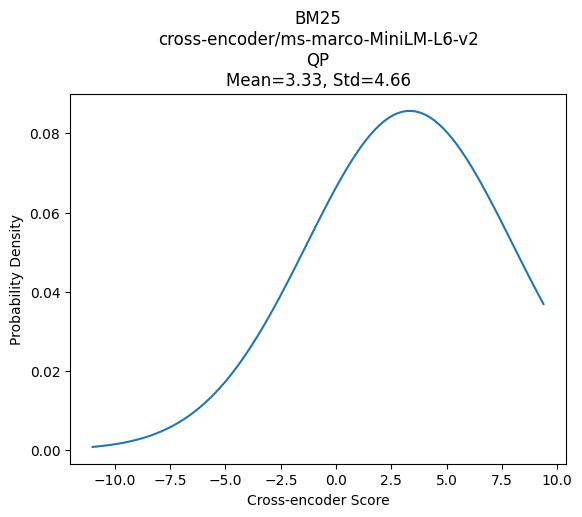

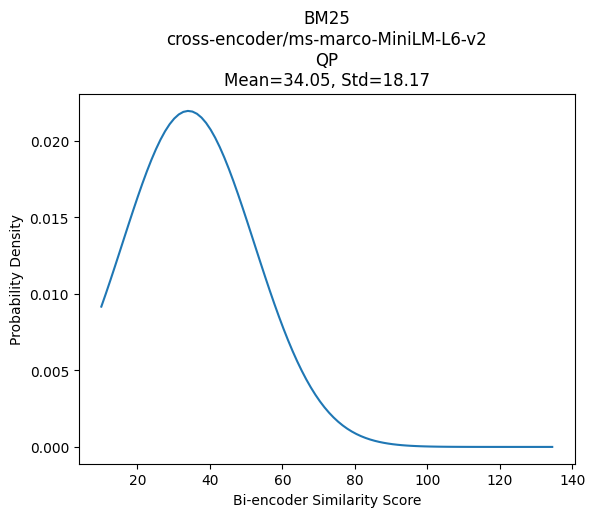

NON-QP


  0%|          | 0/2581 [00:00<?, ?it/s]

  0%|          | 0/2581 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.003      0.003     
6     0.007      0.004     


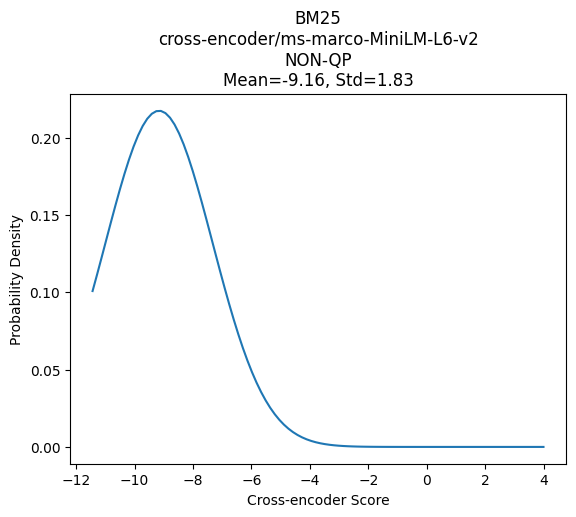

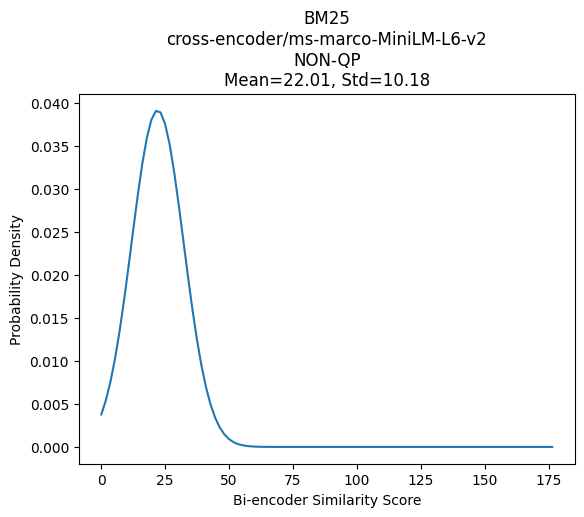

In [ ]:
reranker_name = 'cross-encoder/ms-marco-MiniLM-L6-v2'
model_name = "BM25"
retrieve_k = 6
'''
Top 6     FP@1    R@6
QP        0.698   0.559
NON-QP    0.003   0.007
'''
neg_threshold, neg_sim_threshold, avg_sim_score = 3.33, 10, 34
print("QP ONlY")
hits = get_bm25_results(qp_test)
retrieve_and_rerank(reranker_name, hits, qp_test, [1,6],model_name,neg_threshold, neg_sim_threshold, avg_sim_score)
print("NON-QP")
hits = get_bm25_results(nonQP_test)
retrieve_and_rerank(reranker_name, hits, nonQP_test, [1,6],model_name,neg_threshold, neg_sim_threshold, avg_sim_score)

### Pre-Trained BERT Bi-Encoder + Cross-Encoder

QP ONlY


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.34       0.631     
6     0.517      0.345     


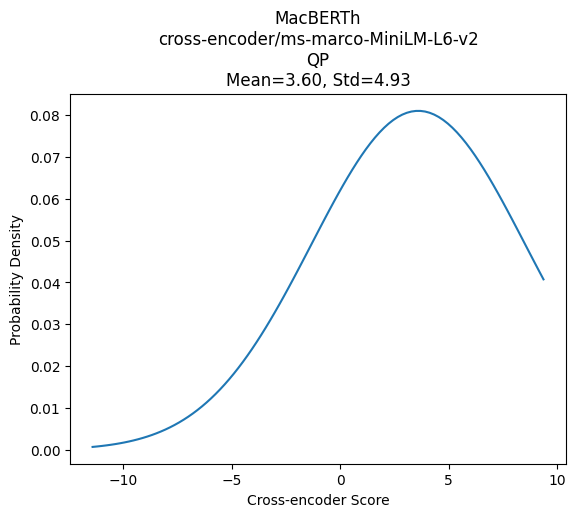

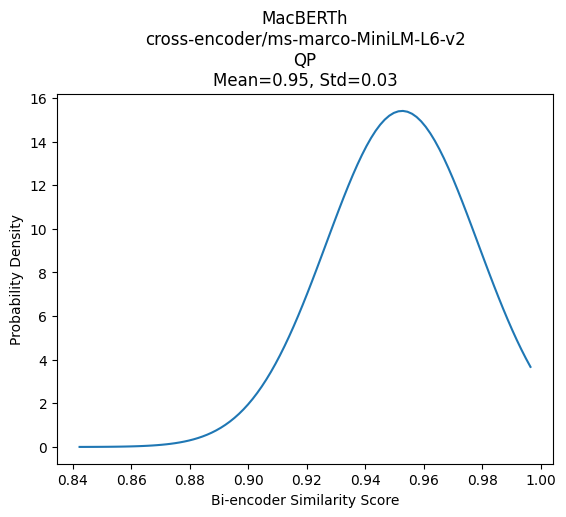

NON-QP


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2581 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.042      0.042     
6     0.048      0.043     


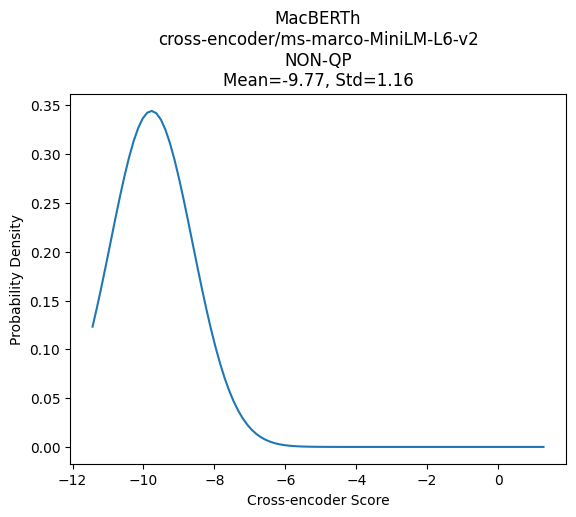

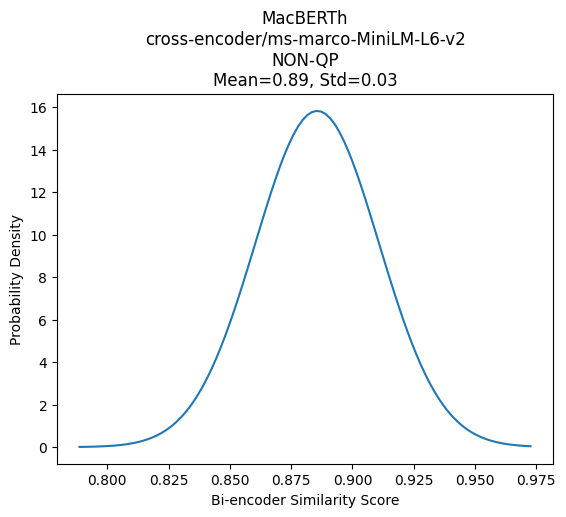

In [ ]:
reranker_name = 'cross-encoder/ms-marco-MiniLM-L6-v2'
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"
state_dict_path = None
retrieve_k = 6
'''
Top 6     FP@1    R@6
QP        0.631   0.517
NON-QP    0.042   0.048
'''
neg_threshold, neg_sim_threshold, avg_sim_score = 3.60, 0.84, 0.95
print("QP ONlY")
hits = get_model_hits(qp_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, qp_test, [1,6],model_name,neg_threshold, neg_sim_threshold, avg_sim_score)
print("NON-QP")
hits = get_model_hits(nonQP_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, nonQP_test, [1,6],model_name,neg_threshold, neg_sim_threshold, avg_sim_score)

QP ONlY


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.264      0.524     
6     0.42       0.292     


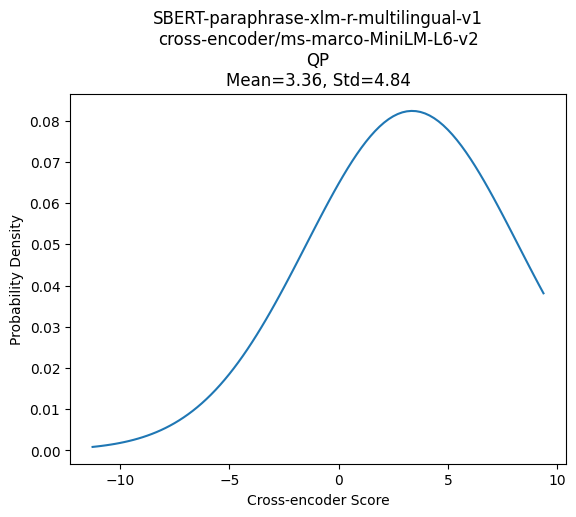

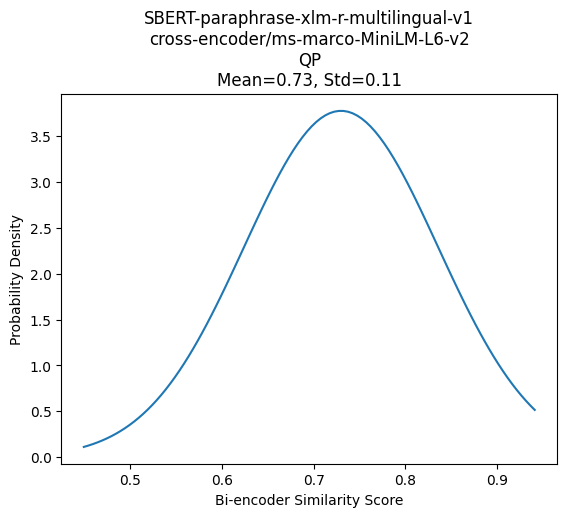

NON-QP


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2581 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.0        0.0       
6     0.0        0.0       


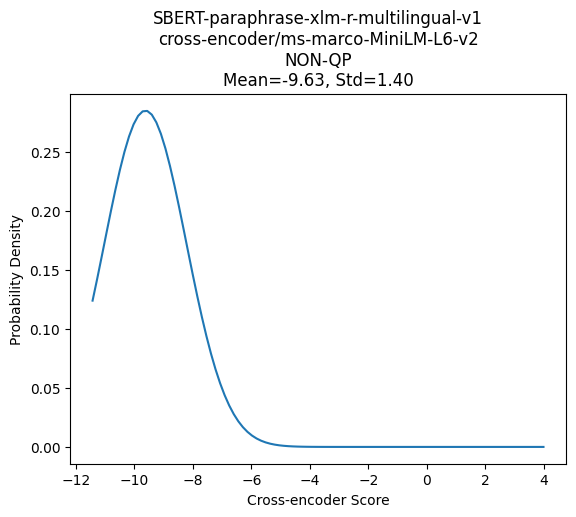

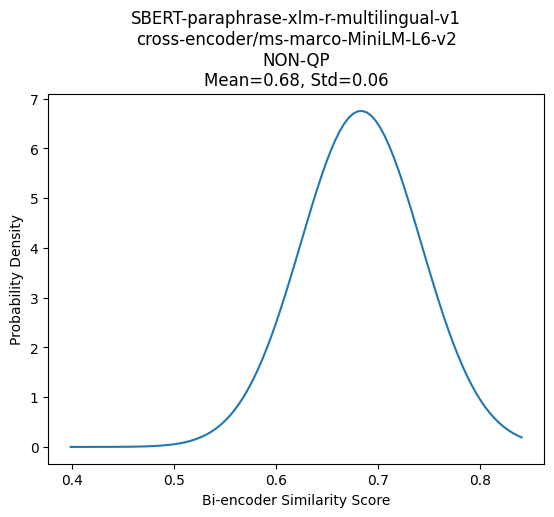

In [ ]:
reranker_name = 'cross-encoder/ms-marco-MiniLM-L6-v2'
model_checkpoint = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
model_name = "SBERT-paraphrase-xlm-r-multilingual-v1"
state_dict_path = None
retrieve_k = 6
'''
Top 6     FP@1    R@6
QP        0.524   0.42
NON-QP    0.000   0.00
'''
neg_threshold, neg_sim_threshold, avg_sim_score = 3.36-4.84, 0.4, 0.73
print("QP ONlY")
hits = get_model_hits(qp_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, qp_test, [1,6],model_name,neg_threshold, neg_sim_threshold, avg_sim_score)
print("NON-QP")
hits = get_model_hits(nonQP_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, nonQP_test, [1,6],model_name,neg_threshold, neg_sim_threshold, avg_sim_score)

### Fine-Tuned BERT Bi-Encoder + Cross-Encoder

QP ONlY


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.394      0.778     
6     0.657      0.487     


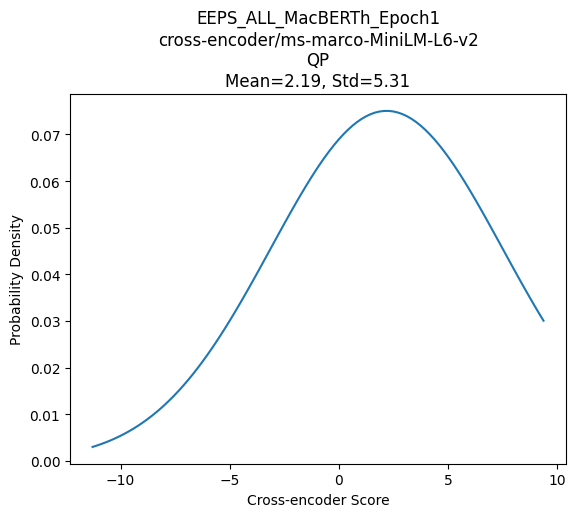

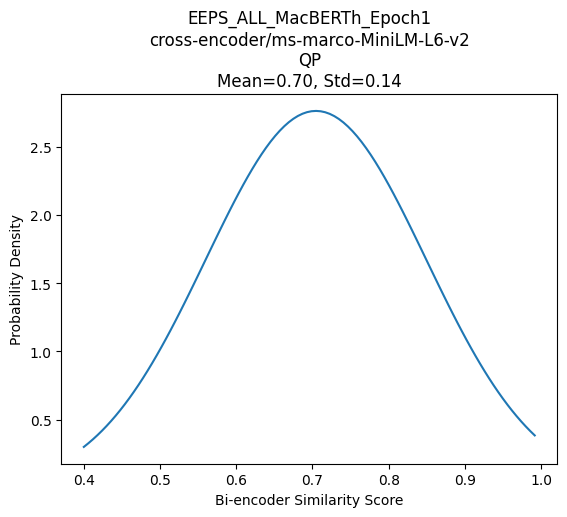

NON-QP


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 22.16 GiB of which 1.06 GiB is free. Process 955605 has 21.10 GiB memory in use. Of the allocated memory 19.37 GiB is allocated by PyTorch, and 1.51 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
reranker_name = 'cross-encoder/ms-marco-MiniLM-L6-v2'
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"
model_round = "ALL"
epoch = "1"
state_dict_path = f"EEPS_{model_round}_MacBERTh_Epoch{epoch}"
retrieve_k = 25
'''
Top 25    FP@1    R@6
QP        0.778   0.657
NON-QP    0.917   0.943
'''
neg_threshold, neg_sim_threshold = 2.19, 0.4
print("QP ONlY")
hits = get_model_hits(qp_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, qp_test, [1,6],state_dict_path,neg_threshold, neg_sim_threshold)
print("NON-QP")
hits = get_model_hits(nonQP_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, nonQP_test, [1,6],state_dict_path,neg_threshold, neg_sim_threshold)

QP ONlY


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.42       0.77      
6     0.632      0.494     


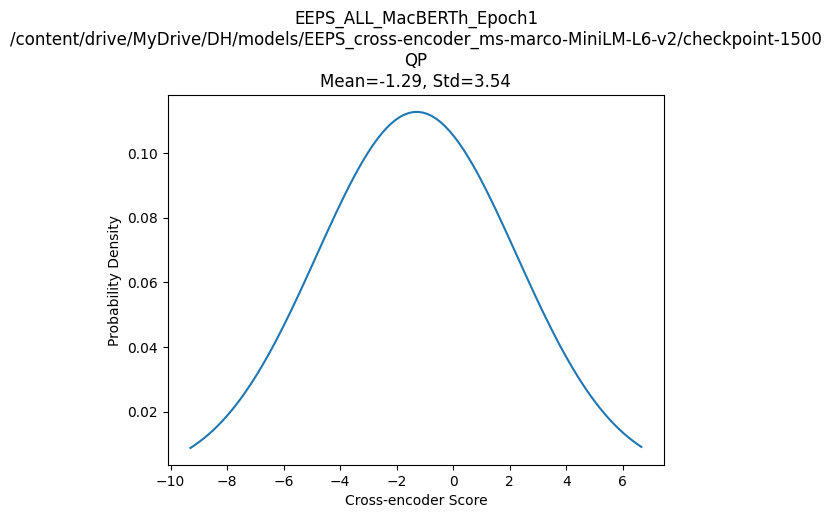

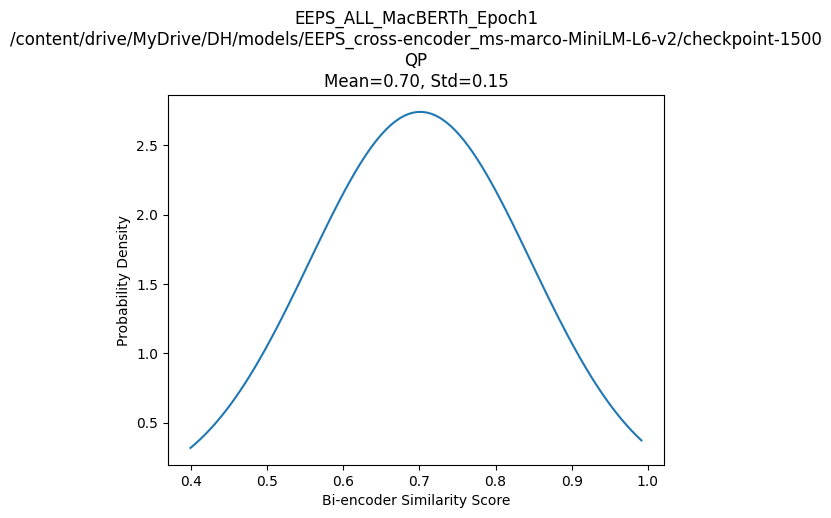

NON-QP


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2581 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.932      0.932     
6     0.942      0.931     


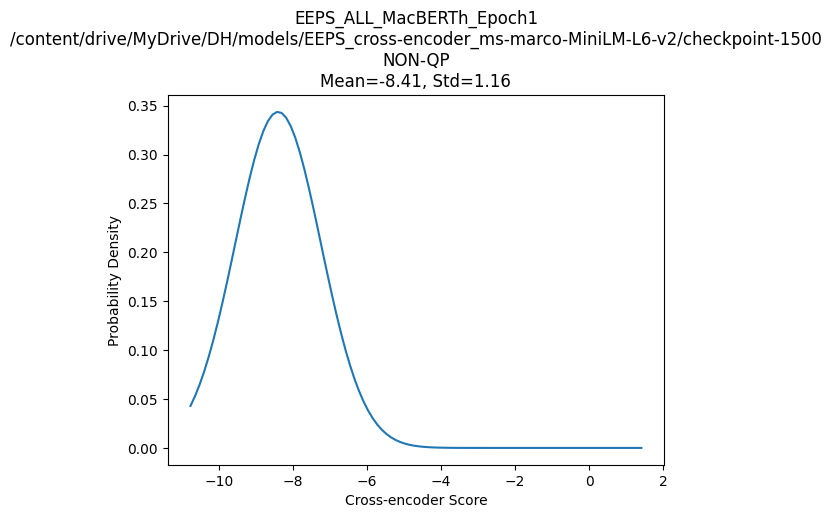

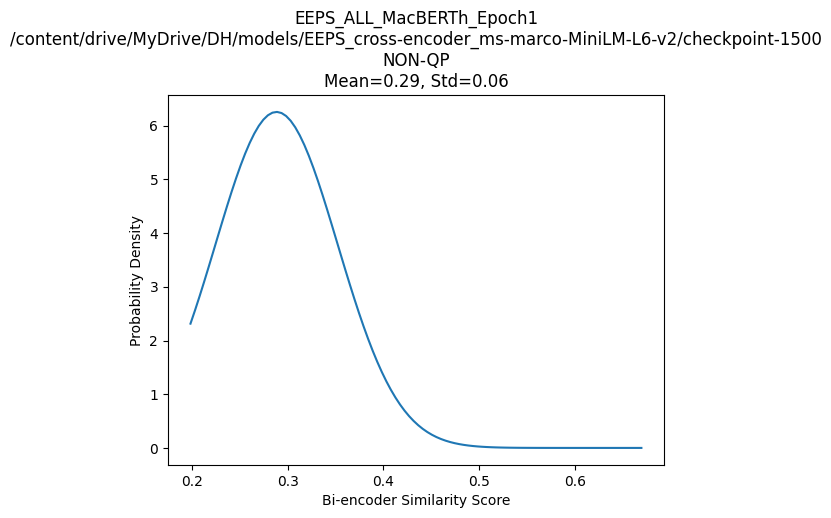

In [ ]:
reranker_name = f'{folder}/models/EEPS_cross-encoder_ms-marco-MiniLM-L6-v2/checkpoint-1500'
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"
model_round = "ALL"
epoch = "1"
state_dict_path = f"EEPS_{model_round}_MacBERTh_Epoch{epoch}"
retrieve_k = 25
'''
Checkpoint 1500
Top 25    FP@1    R@6
QP        0.77    0.632
NON-QP    0.932   0.942

'''
neg_threshold, neg_sim_threshold, avg_sim_score = 0, 0.4, 0.72
print("QP ONlY")
hits = get_model_hits(qp_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, qp_test, [1,6],state_dict_path,neg_threshold, neg_sim_threshold, avg_sim_score)
print("NON-QP")
hits = get_model_hits(nonQP_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, nonQP_test, [1,6],state_dict_path,neg_threshold, neg_sim_threshold, avg_sim_score)

QP ONlY


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.387      0.798     
6     0.66       0.536     


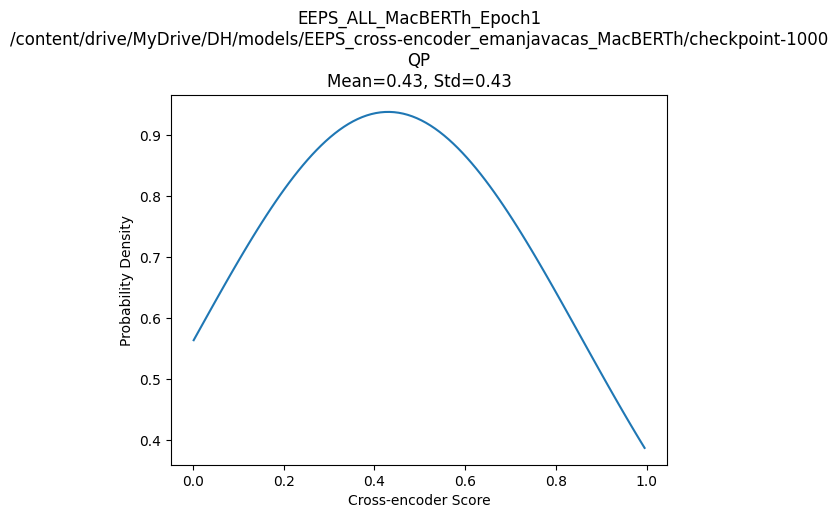

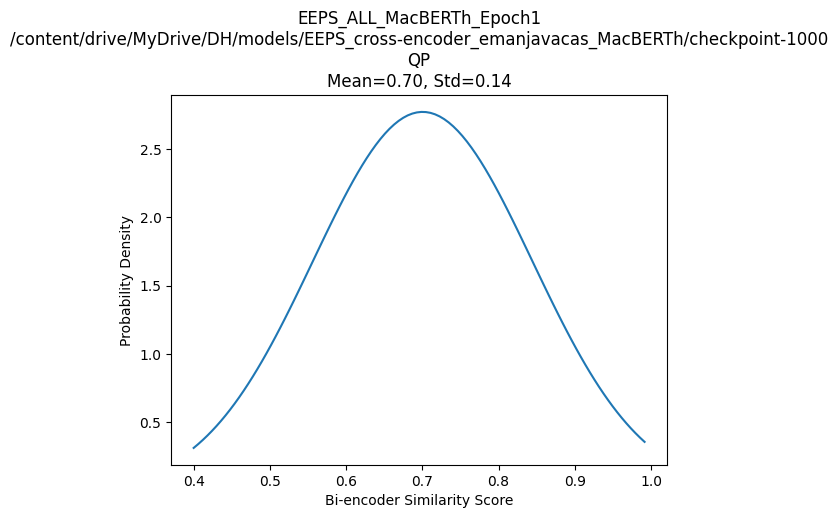

NON-QP


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2581 [00:00<?, ?it/s]

k     R@k        FP@k      
-------------------------
1     0.923      0.923     
6     0.941      0.922     


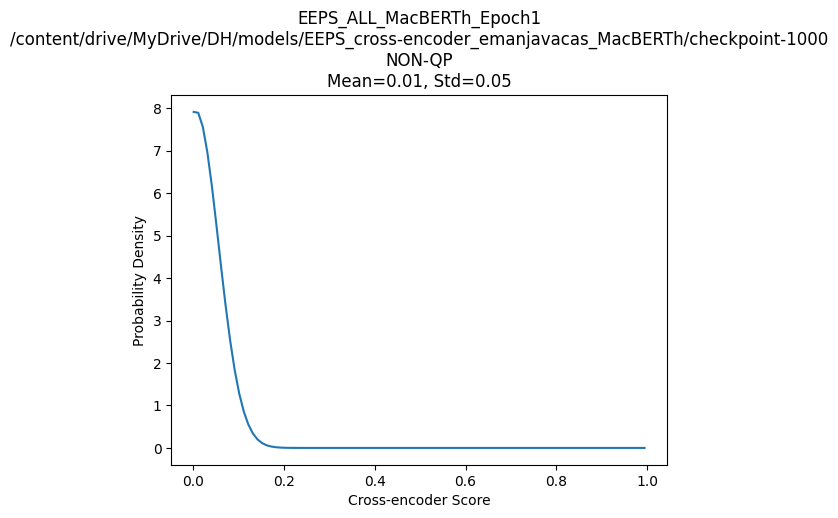

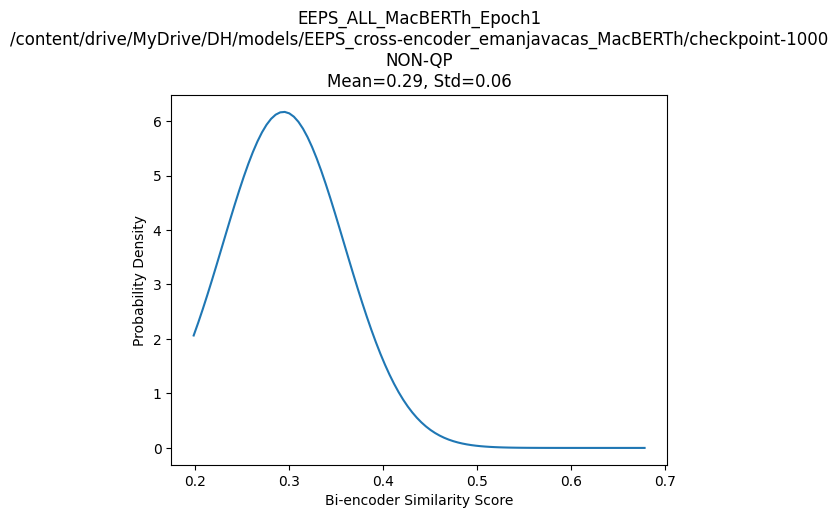

In [ ]:
reranker_name = f"{folder}/models/EEPS_cross-encoder_emanjavacas_MacBERTh/checkpoint-1000"
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"
model_round = "ALL"
epoch = "1"
state_dict_path = f"EEPS_{model_round}_MacBERTh_Epoch{epoch}"
retrieve_k = 25
'''
Top 25    FP@1    R@6
QP        0.798    0.66
NON-QP    0.924    0.942

'''
neg_threshold, neg_sim_threshold, avg_sim_score = 0.43, 0.4, 0.72
print("QP ONlY")
hits = get_model_hits(qp_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, qp_test, [1,6],state_dict_path,neg_threshold, neg_sim_threshold, avg_sim_score)
print("NON-QP")
hits = get_model_hits(nonQP_test,model_checkpoint, model_name, state_dict_path, retrieve_k)
retrieve_and_rerank(reranker_name, hits, nonQP_test, [1,6],state_dict_path,neg_threshold, neg_sim_threshold, avg_sim_score)

# Cross Encoder FINE-TUNING

## Set up datasets

In [ ]:
len(dev_data), len(train_data)

(6485, 49408)

In [ ]:
def get_dataset(data):
  my_dataset = []
  for entry in data.values():
    query_id, query_text, pos_id = entry['input']
    my_dataset.append((query_text, query_id))
  return my_dataset

eval_dataset = get_dataset(dev_data)
train_dataset = get_dataset(train_data)

print(len(eval_dataset), len(train_dataset))

6485 49408


In [ ]:
# get hard negatives using retriever
def get_train_dataset(data):
  final_dataset = {"query":[], "passage":[],'score':[]}
  id_batches = make_batches([x[1] for x in data], batch_size = 10000)
  query_batches = make_batches([x[0] for x in data], batch_size = 10000)
  for query_ids, queries in zip(id_batches, query_batches):
    for query_text, query_id in zip(queries, query_ids):
      neg_id = ALL_NEGATIVES[str(q_id_to_neg_idx[query_text])][0]
      final_dataset["query"].extend([query_text, query_text])
      final_dataset["passage"].extend([bible_verses_no_prepend[v_id_to_idx[query_id]], bible_verses_no_prepend[v_id_to_idx[neg_id]]])
      final_dataset["score"].extend([1.0, 0.0])
  return final_dataset

def get_dev_dataset(data):
  final_dataset = []
  id_batches = make_batches([x[1] for x in data], batch_size = 10000)
  query_batches = make_batches([x[0] for x in data], batch_size = 10000)
  for query_ids, queries in zip(id_batches, query_batches):
    for pid, text in zip(query_ids, queries):
      my_dict = {'query': text,
                 'positive':[],
                 'documents':[bible_verses_no_prepend[v_id_to_idx[nid]] for nid in ALL_NEGATIVES[str(q_id_to_neg_idx[text])]]
                 }
      if pid == "NonQP 0.0":
        my_dict['positive'].append(bible_verses_no_prepend[-1])
        my_dict['documents'].append(bible_verses_no_prepend[-1])
      else:
        for v_id in PV[pid]:
          for p_id in parallel[v_id]['pos']:
            if " - " in p_id: continue
            my_dict['positive'].append(bible_verses_no_prepend[v_id_to_idx[p_id]])
            my_dict['documents'].append(bible_verses_no_prepend[v_id_to_idx[p_id]])
      final_dataset.append(my_dict)
  return final_dataset

In [ ]:
eval_dataset = get_dev_dataset(eval_dataset)
len(eval_dataset)

1 batches
1 batches


6485

In [ ]:
train_dataset = get_train_dataset(train_dataset)
len(train_dataset['passage']), len(train_dataset['score']), len(train_dataset['query'])

5 batches
5 batches


(98816, 98816, 98816)

In [ ]:
train_dataset['query'][-2:], train_dataset['passage'][-2:], train_dataset['score'][-2:]

(['John 17.24. John 12.26.', 'John 17.24. John 12.26.'],
 ['None', 'but I will come to you.'],
 [1.0, 0.0])

## Load Datasets and Train

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder, CrossEncoderTrainingArguments
from sentence_transformers.cross_encoder.evaluation import CrossEncoderRerankingEvaluator
from sentence_transformers.cross_encoder.losses import BinaryCrossEntropyLoss
from sentence_transformers.cross_encoder.trainer import CrossEncoderTrainer

In [ ]:
from datetime import datetime

train_batch_size = 16

num_epochs = 1
max_seq_length = 512

# base_model = 'cross-encoder/ms-marco-MiniLM-L6-v2'
base_model = 'emanjavacas/MacBERTh'
model = CrossEncoder(base_model, num_labels=1)
loss = BinaryCrossEntropyLoss(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emanjavacas/MacBERTh and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
eval_rand_keys = random.sample(eval_dataset, 200)
evaluator = CrossEncoderRerankingEvaluator(eval_rand_keys,
                                          name="EEPS-CE-dev",
                                          batch_size=train_batch_size,
                                           show_progress_bar =True
                                           )
print(evaluator(model))
''' 'cross-encoder/ms-marco-MiniLM-L6-v2'
    {'EEPS-CE-dev_map': 0.8100232714045214,
    'EEPS-CE-dev_mrr@10': 0.9317619047619047,
    'EEPS-CE-dev_ndcg@10': 0.8821204444964323,
    'EEPS-CE-dev_base_map': 0.2350878787878788,
    'EEPS-CE-dev_base_mrr@10': 0.14714285714285708,
    'EEPS-CE-dev_base_ndcg@10': 0.3979281462734019}
'''

{'EEPS-CE-dev_map': 0.507476902958153, 'EEPS-CE-dev_mrr@10': 0.5393333333333333, 'EEPS-CE-dev_ndcg@10': 0.645749457065588, 'EEPS-CE-dev_base_map': 0.2350878787878788, 'EEPS-CE-dev_base_mrr@10': 0.14714285714285708, 'EEPS-CE-dev_base_ndcg@10': 0.3979281462734019}


" {'EEPS-CE-dev_map': 0.8100232714045214, \n    'EEPS-CE-dev_mrr@10': 0.9317619047619047, \n    'EEPS-CE-dev_ndcg@10': 0.8821204444964323, \n    'EEPS-CE-dev_base_map': 0.2350878787878788, \n    'EEPS-CE-dev_base_mrr@10': 0.14714285714285708, \n    'EEPS-CE-dev_base_ndcg@10': 0.3979281462734019}\n"

In [ ]:
if 'cross' not in base_model:
  base_model = f'cross-encoder_{base_model}'
model_save_path = "{}/models/{}".format(
    folder,
    f"EEPS_{re.sub('/','_',base_model)}",
    # datetime.now().date()
)
print(model_save_path)

/content/drive/MyDrive/DH/models/EEPS_cross-encoder_emanjavacas_MacBERTh


In [ ]:
import sys
sys.modules["wandb"] = None

In [ ]:
train_dataset = Dataset.from_dict(train_dataset)

In [ ]:
num_epochs = 1
args = CrossEncoderTrainingArguments(
        # Required parameter:
        output_dir=model_save_path,
        # Optional training parameters:
        num_train_epochs=num_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=train_batch_size,
        learning_rate=2e-5,
        warmup_ratio=0.1,
        fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
        bf16=True,  # Set to True if you have a GPU that supports BF16
        load_best_model_at_end=True,
        metric_for_best_model="EEPS-CE-dev_ndcg@10",
        # Optional tracking/debugging parameters:
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=3,
    )


In [ ]:
trainer = CrossEncoderTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    loss=loss,
    evaluator=evaluator,

)
trainer.train()
'''
'cross-encoder/ms-marco-MiniLM-L6-v2'
Step	Training Loss	Validation Loss	Eeps-ce-dev Map	Eeps-ce-dev Mrr@10	Eeps-ce-dev Ndcg@10	Eeps-ce-dev Base Map	Eeps-ce-dev Base Mrr@10	Eeps-ce-dev Base Ndcg@10
500	0.594700	No log	0.879551	0.966250	0.928438	0.235088	0.147143	0.397928
1000	0.190300	No log	0.909086	0.988333	0.948796	0.235088	0.147143	0.397928
1500	0.160900	No log	0.900389	0.985833	0.942513	0.235088	0.147143	0.397928
2000	0.143500	No log	0.899609	0.981833	0.941723	0.235088	0.147143	0.397928

'emanjavacas/MacBERTh'
Step	Training Loss	Validation Loss	Eeps-ce-dev Map	Eeps-ce-dev Mrr@10	Eeps-ce-dev Ndcg@10	Eeps-ce-dev Base Map	Eeps-ce-dev Base Mrr@10	Eeps-ce-dev Base Ndcg@10
500	0.322800	No log	0.934454	0.987500	0.961796	0.235088	0.147143	0.397928
1000	0.169800	No log	0.941330	0.988333	0.963905	0.235088	0.147143	0.397928
1500	0.143000	No log	0.935820	0.986000	0.963606	0.235088	0.147143	0.397928

'''

Step,Training Loss,Validation Loss,Eeps-ce-dev Map,Eeps-ce-dev Mrr@10,Eeps-ce-dev Ndcg@10,Eeps-ce-dev Base Map,Eeps-ce-dev Base Mrr@10,Eeps-ce-dev Base Ndcg@10
500,0.322800,No log,0.934454,0.987500,0.961796,0.235088,0.147143,0.397928
1000,0.169800,No log,0.941330,0.988333,0.963905,0.235088,0.147143,0.397928
1500,0.143000,No log,0.935820,0.986000,0.963606,0.235088,0.147143,0.397928


KeyboardInterrupt: 

In [ ]:
evaluator(model)